In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sipm.util.functions as func
import pandas as pd
import glob
import scipy
from scipy.interpolate import interp1d
import csv
import os
from sipm.analysis.SipmCalibration import SipmCalibration
import yaml

In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
!pwd


/home/as111/sipm-analysis


## Example waveforms

/scratch/gpfs/GALBIATI/data/sipm//reflector_studies/2023-04-27/2023-04-27_volt_65_pos_bottom_light_laser_coinc_laser_cond_calibration/0/wave1.dat
11016 events


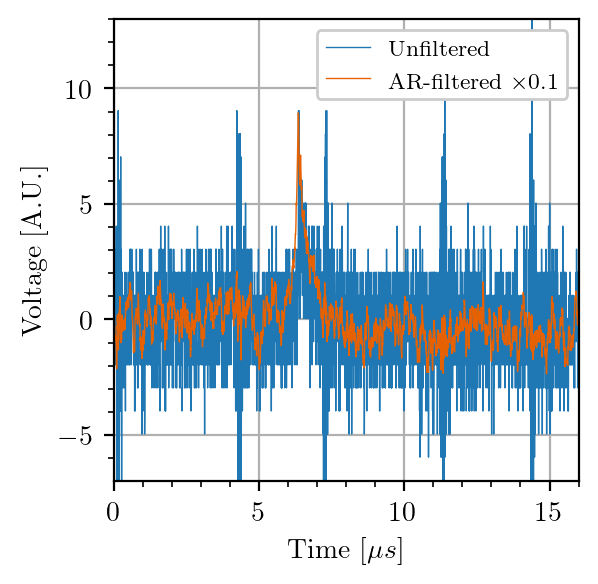

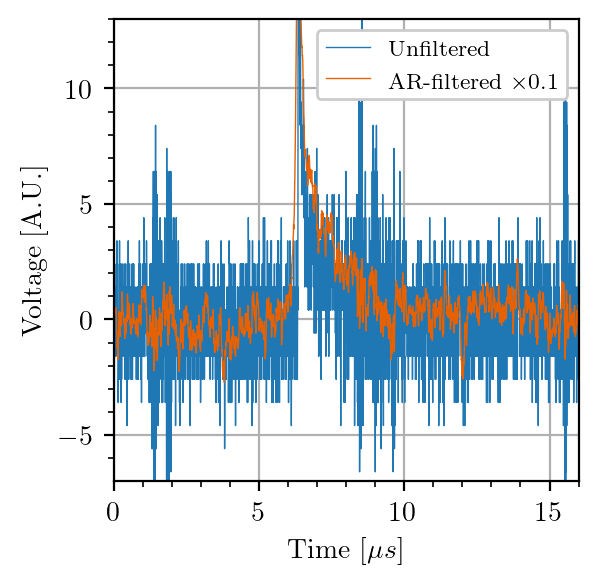

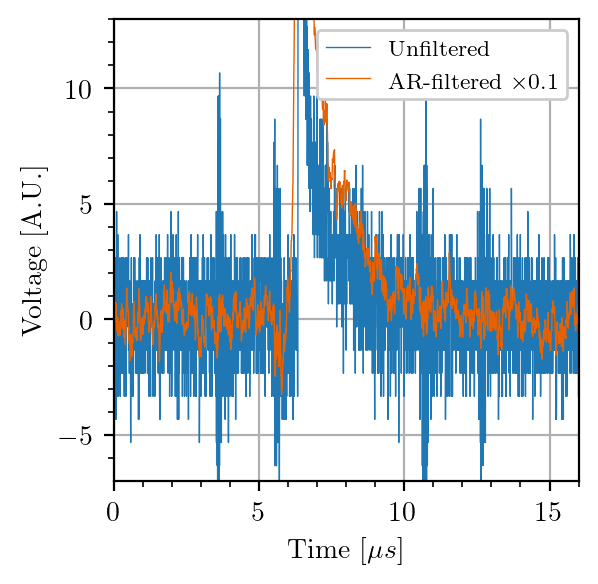

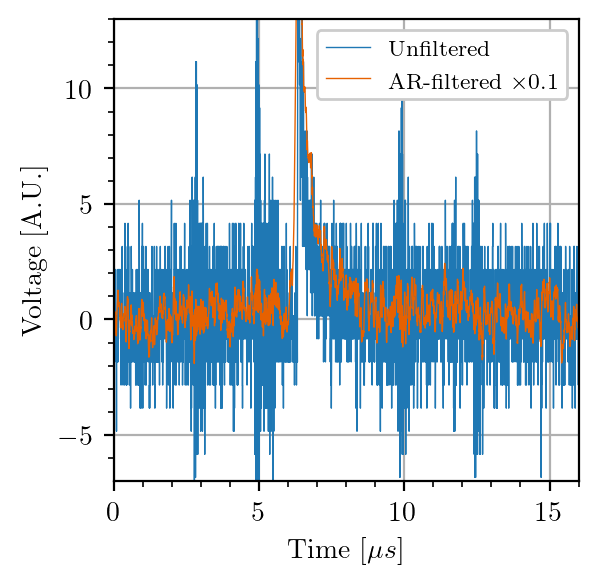

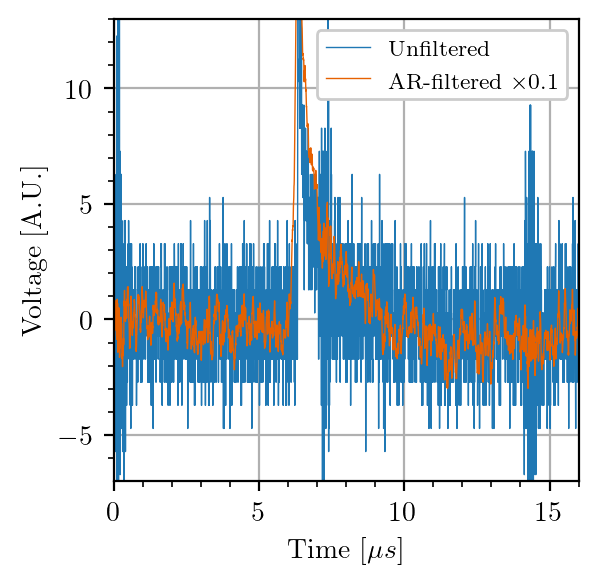

In [4]:
import sipm.recon.WaveformDataset as wfd
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/'
direc = '2023-04-27/2023-04-27_volt_65_pos_bottom_light_laser_coinc_laser_cond_calibration/0/'
ch = 1
evid = np.arange(5, 10)
dset = wfd.WaveformDataset(path='{}{}'.format(
    data_dir, direc), pol=-1, channels=range(4))
wfs, arwfs = dset.ch[ch].get_waveforms(ev=evid, ar_filter=True)

for i, wf in enumerate(wfs):
    plt.figure(i, figsize=(3, 3))
    plt.plot(dset.ch[ch].time, wf, label='Unfiltered', linewidth=0.5)
    plt.plot(dset.ch[ch].time, arwfs[i]*0.1,
             label=r'AR-filtered $\times0.1$', linewidth=0.5)
    plt.legend(loc='upper right')
    plt.xlabel(r'Time [$\mu s$]')
    plt.ylabel(r'Voltage [A.U.]')
    plt.minorticks_on()
    plt.grid()
    plt.xlim(0, 16)
    plt.ylim(-7, 13)

# Load pre-processed h5 files
These files should be processed by `exe/laser_pulse.py` script.

In [5]:
positions = ['top','bottom']
voltages = [63,65,67,69,71]
channels = [0,1,2,3]
metadata_dict = {}
for pos in positions:
    metadata_dict[pos] = {}
    for ch in channels:
        metadata_dict[pos][ch] = {}
        for volt in voltages:
            metadata_dict[pos][ch][volt] = {'metadata':{
                'date':'2023-04-28' if pos=='top' else '2023-04-27',
                'volt': volt,
                'pos': pos,
                'light': 'laser',
                'coinc': 'laser',
                'cond': 'calibration',
                'run': '*',
                'ch': ch
            }}

In [6]:
calibration = SipmCalibration(
    positions=positions,
    voltages=voltages,
    channels=channels,
    directory='/scratch/gpfs/as111/results/',
    metadata_dict=metadata_dict,
    script='laser_pulse',
    merge=True,
    verbose=True
)
calibration.load_files()

2023-04-28 63V top laser coinc=laser cond=calibration run* ch0 script=laser_pulse.py - 10 files 109088 events
2023-04-28 65V top laser coinc=laser cond=calibration run* ch0 script=laser_pulse.py - 10 files 109871 events
2023-04-28 67V top laser coinc=laser cond=calibration run* ch0 script=laser_pulse.py - 10 files 109737 events
2023-04-28 69V top laser coinc=laser cond=calibration run* ch0 script=laser_pulse.py - 10 files 107449 events
2023-04-28 71V top laser coinc=laser cond=calibration run* ch0 script=laser_pulse.py - 10 files 107862 events
2023-04-28 63V top laser coinc=laser cond=calibration run* ch1 script=laser_pulse.py - 10 files 109088 events
2023-04-28 65V top laser coinc=laser cond=calibration run* ch1 script=laser_pulse.py - 10 files 109871 events
2023-04-28 67V top laser coinc=laser cond=calibration run* ch1 script=laser_pulse.py - 10 files 109737 events
2023-04-28 69V top laser coinc=laser cond=calibration run* ch1 script=laser_pulse.py - 10 files 107449 events
2023-04-28

## Baseline quality cut
To avoid pre-trigger pulses or abnormal fluctuations, we require that the RMS variation in the baseline region ($t<t_{\rm trigger}-0.5~\rm\mu s$) be less than some threshold values.
This baseline cut normalizes the baseline mean distribution.

In [7]:
bsl_thre_dict = {}
for pos in positions:
    bsl_thre_dict[pos] = {}
    for ch in channels:
        bsl_thre_dict[pos][ch] = {}
        for volt in voltages:
            if (pos=='top' and ch==1) or (pos=='bottom' and ch==2):
                bsl_thre_dict[pos][ch][volt] = 3.0
            else:
                bsl_thre_dict[pos][ch][volt] = 2.5

In [8]:
calibration.baseline_analysis(bsl_thre_dict)

top ch0 63V cut fraction = 0.07059%
top ch0 65V cut fraction = 0.11286%
top ch0 67V cut fraction = 0.15309%
top ch0 69V cut fraction = 0.17124%
top ch0 71V cut fraction = 0.17430%
top ch1 63V cut fraction = 0.15400%
top ch1 65V cut fraction = 0.41048%
top ch1 67V cut fraction = 0.34173%
top ch1 69V cut fraction = 0.30619%
top ch1 71V cut fraction = 0.29297%
top ch2 63V cut fraction = 0.24476%
top ch2 65V cut fraction = 0.42777%
top ch2 67V cut fraction = 0.26882%
top ch2 69V cut fraction = 0.29968%
top ch2 71V cut fraction = 0.31429%
top ch3 63V cut fraction = 0.06967%
top ch3 65V cut fraction = 0.11468%
top ch3 67V cut fraction = 0.14945%
top ch3 69V cut fraction = 0.18427%
top ch3 71V cut fraction = 0.21973%
bottom ch0 63V cut fraction = 0.07123%
bottom ch0 65V cut fraction = 32.83238%
bottom ch0 67V cut fraction = 0.13810%
bottom ch0 69V cut fraction = 0.16611%
bottom ch0 71V cut fraction = 0.14430%
bottom ch1 63V cut fraction = 0.11563%
bottom ch1 65V cut fraction = 32.89029%
botto

Text(0.07, 0.5, 'Count')

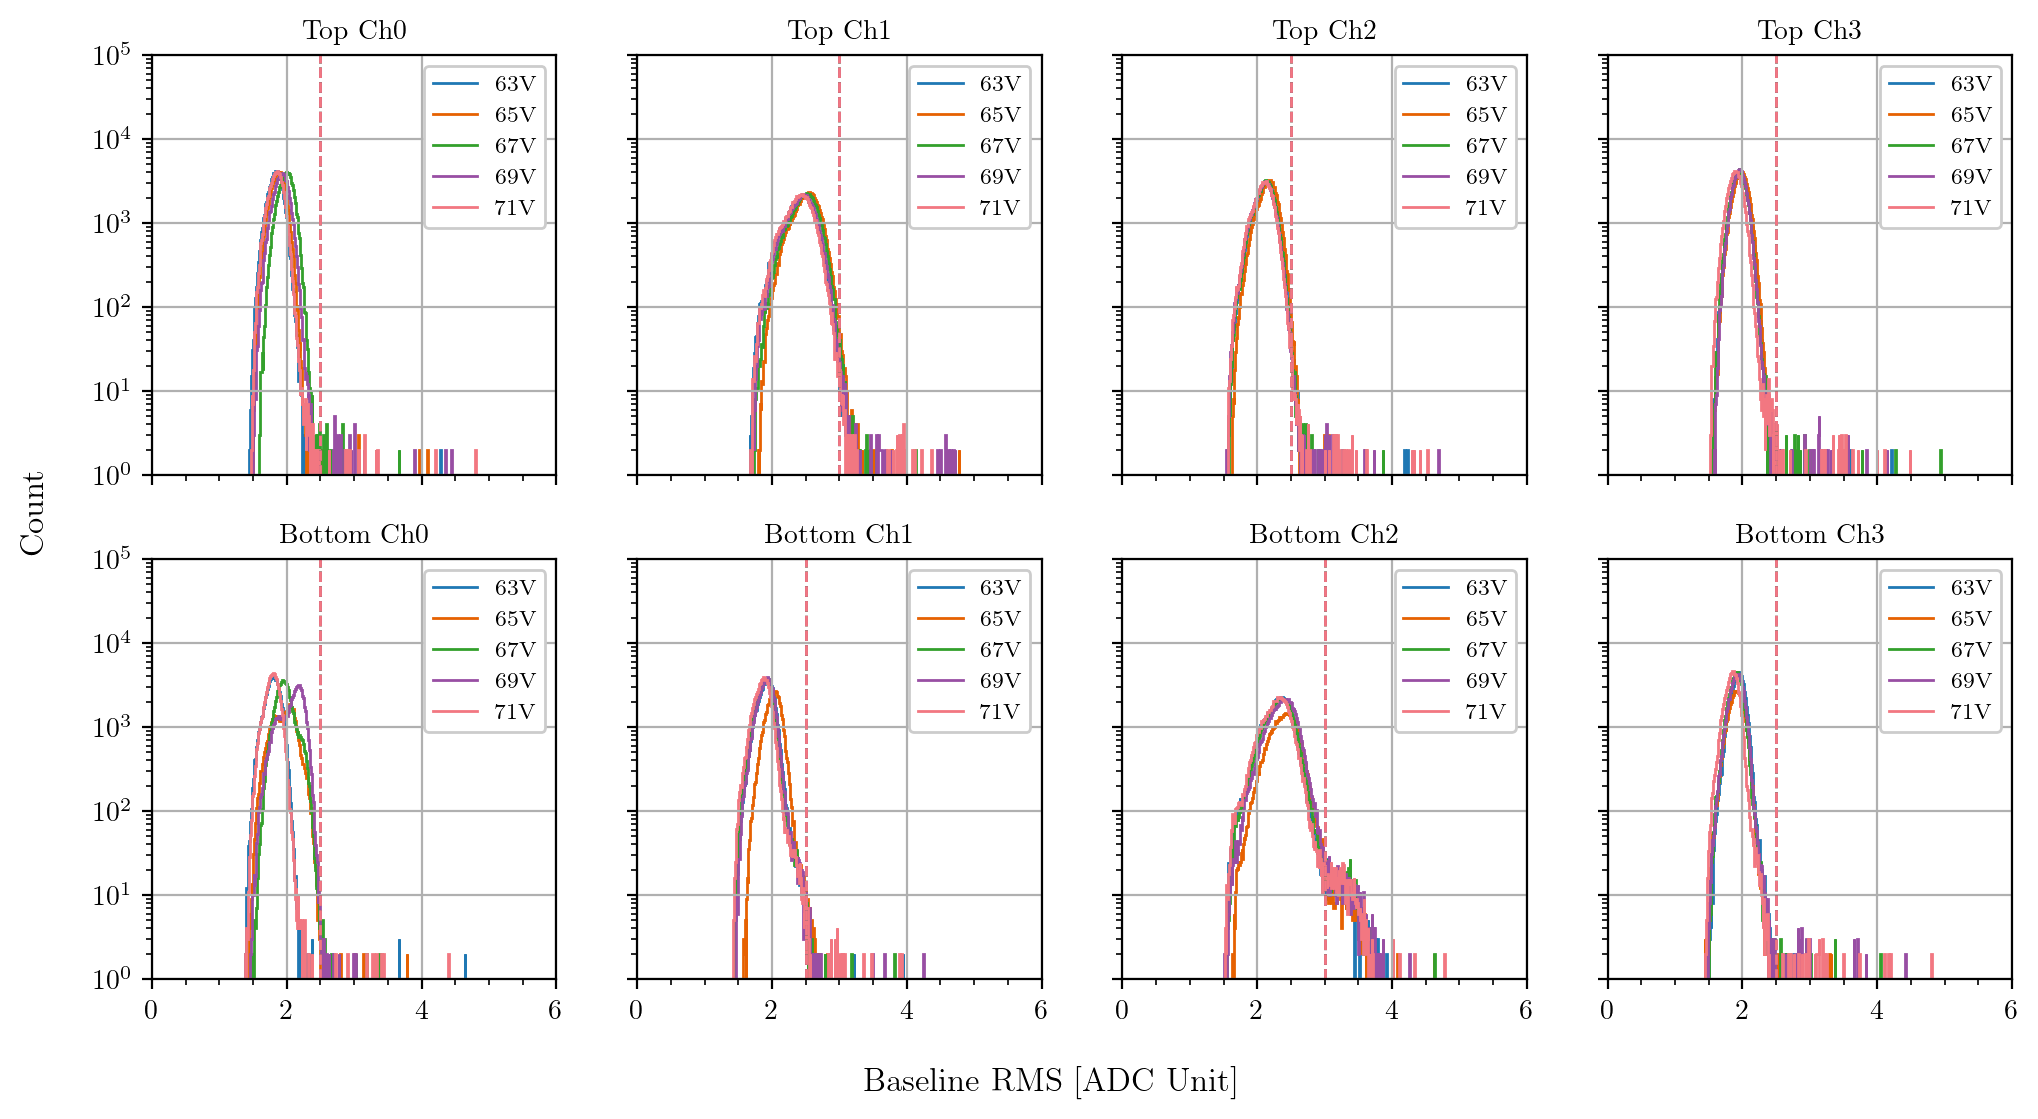

In [9]:
# Make plots for all datasets
# Baseline RMS
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            axs[i, j].stairs(calibration.baseline[pos][ch][volt]['rms_hist'],
                             calibration.baseline[pos][ch][volt]['rms_bins'],
                             label=f'{volt}V', color=f'C{k}')
            th = calibration.baseline[pos][ch][volt]['rms_threshold']
            axs[i, j].plot([th, th], [1, 1e5], f'C{k}--', linewidth=1)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_ylim(1, 1e5)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel('Baseline RMS [ADC Unit]', y=0.01)
fig.supylabel('Count', x=0.07)

Text(0.07, 0.5, 'Count')

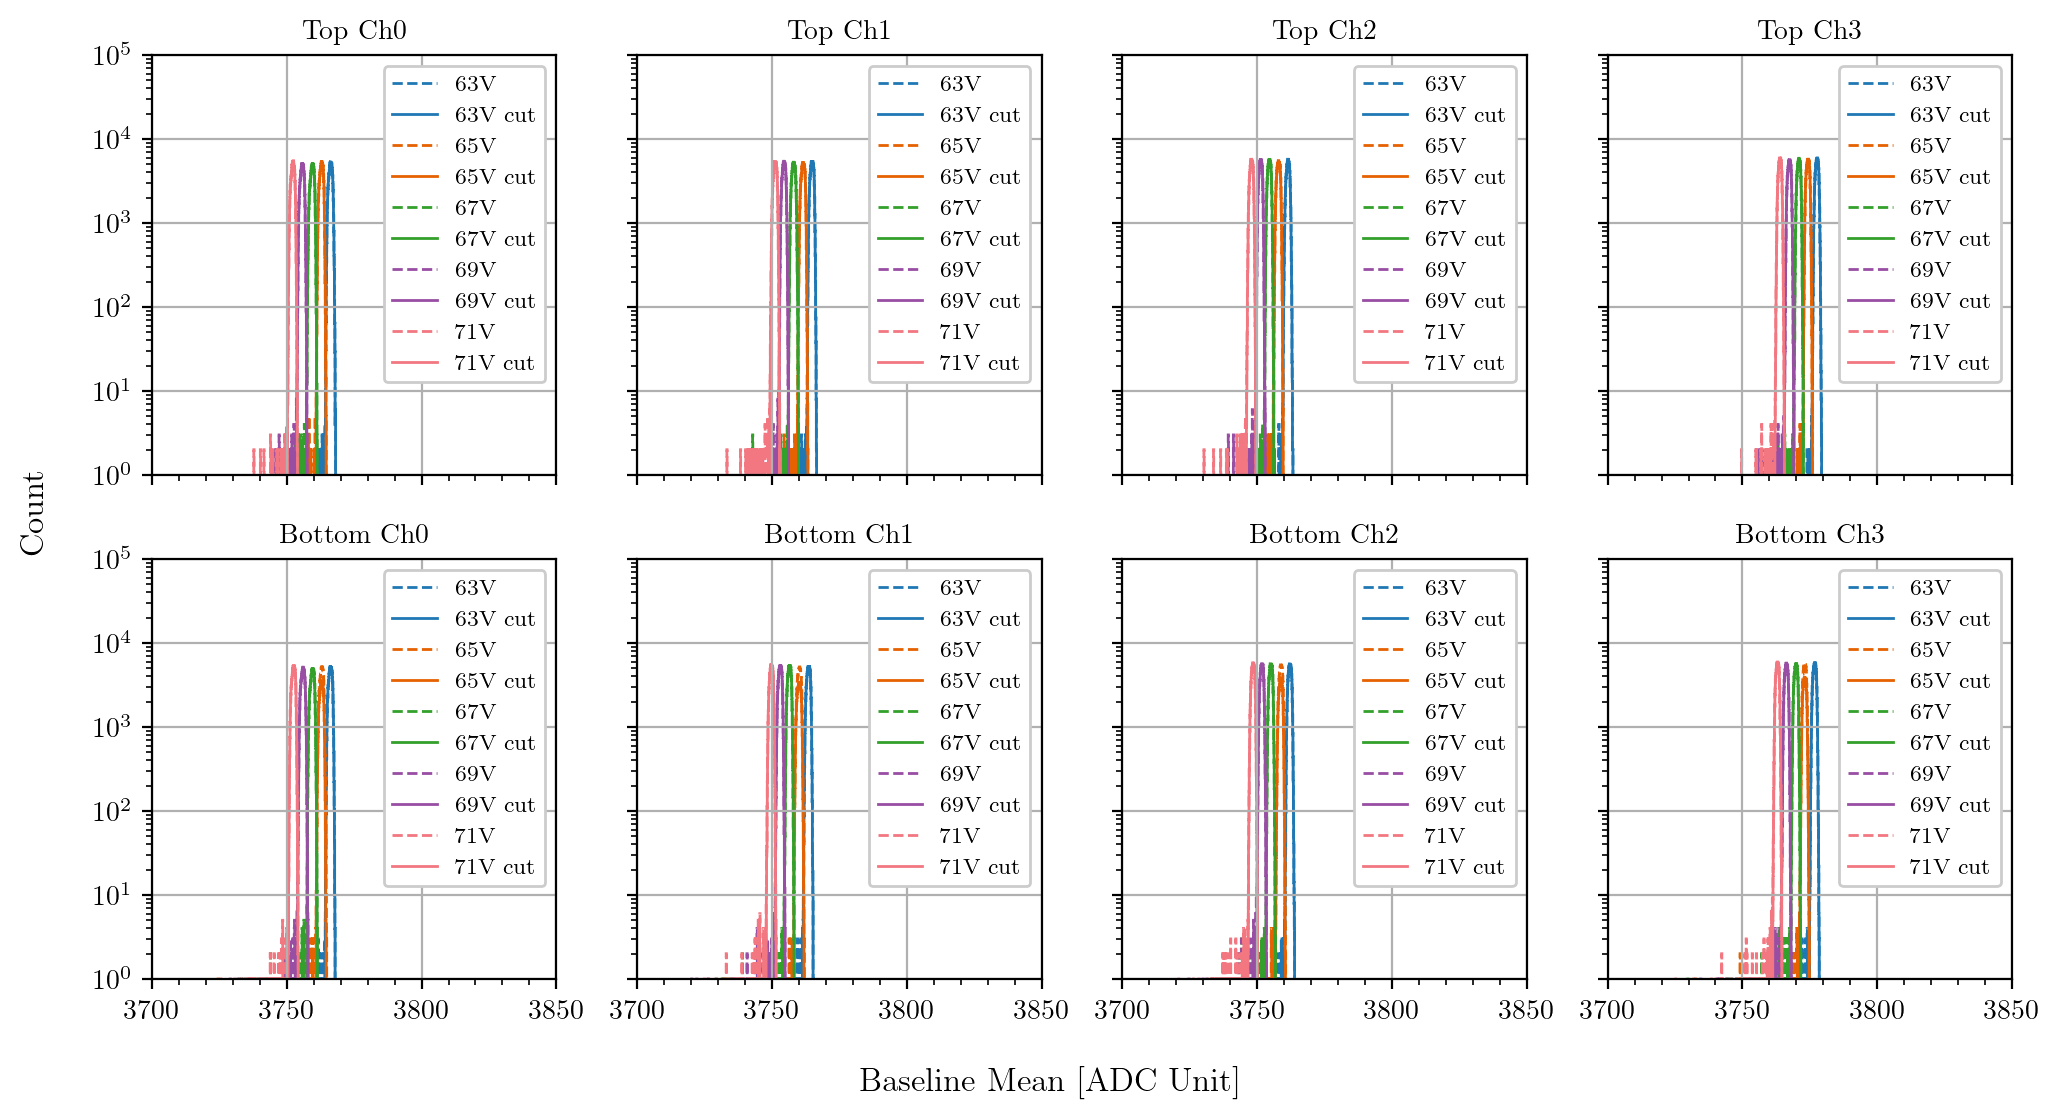

In [10]:
# Make plots for all datasets
# Baseline mean
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            axs[i, j].stairs(calibration.baseline[pos][ch][volt]['mean_hist'],
                             calibration.baseline[pos][ch][volt]['mean_bins'],
                             label=f'{volt}V', color=f'C{k}', linestyle='--')
            axs[i, j].stairs(calibration.baseline[pos][ch][volt]['mean_hist_cut'],
                             calibration.baseline[pos][ch][volt]['mean_bins_cut'],
                             label=f'{volt}V cut', color=f'C{k}')
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_ylim(1, 1e5)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel('Baseline Mean [ADC Unit]', y=0.01)
fig.supylabel('Count', x=0.07)

Plots for top ch0 63V


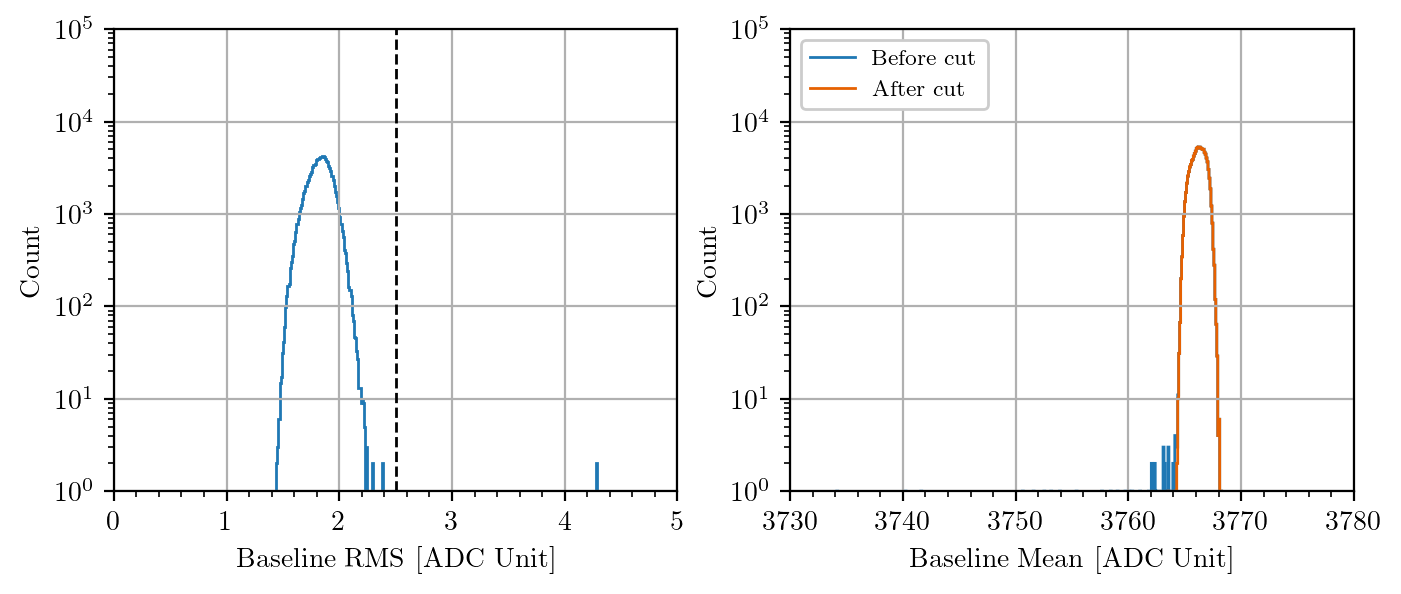

In [11]:
# Make plots for selected dataset
pos = 'top'
ch = 0
volt = 63
print(f'Plots for {pos} ch{ch} {volt}V')
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3)

# rms
axs[0].stairs(calibration.baseline[pos][ch][volt]['rms_hist'],
              calibration.baseline[pos][ch][volt]['rms_bins'])
th = calibration.baseline[pos][ch][volt]['rms_threshold']
axs[0].plot([th, th], [1, 1e5], 'k--', linewidth=1)
axs[0].set_ylim(1, 1e5)
axs[0].set_yscale('log')
axs[0].set_xlabel('Baseline RMS [ADC Unit]')
axs[0].set_ylabel('Count')
axs[0].minorticks_on()
axs[0].grid()

# mean
axs[1].stairs(calibration.baseline[pos][ch][volt]['mean_hist'],
              calibration.baseline[pos][ch][volt]['mean_bins'],
              label='Before cut')
axs[1].stairs(calibration.baseline[pos][ch][volt]['mean_hist_cut'],
              calibration.baseline[pos][ch][volt]['mean_bins_cut'],
              label='After cut')
axs[1].legend()
axs[1].set_yscale('log')
axs[1].set_ylim(1, 1e5)
axs[1].set_xlim(3730, 3780)
axs[1].set_xlabel('Baseline Mean [ADC Unit]')
axs[1].set_ylabel('Count')
axs[1].minorticks_on()
axs[1].grid()

## Filtered amplitude & DiCT analysis
The PE peak positions are identified with ``scipy.signal.find_peaks``.
Let $A_k$ be the peak position of the $k$-PE peak (including $k=0$). 
The boundary between $k-1$ PEs and $k$ PEs is defined as $(A_{k-1}+A_{k})/2$.
The lower boundary of the 0th PE is $A_0-0.5(A_1-A_0)$ and similarly for the upper boundary of the highest identifiable PE.
One exception is bottom ch3 which has asymmetric peaks. See code for the modified boundary criterion.
The vertical dashed lines in the finger plots represent the boundaries.

Let $P_k$ be the fraction of events within the $k$-PE boundaries. 
It can be fitted by the [compound Poisson distribution](https://ieeexplore.ieee.org/document/5402300) describing a binomial chain process, with parameter $p$ being the DiCT probability and $\mu$ being the Poisson mean of primary PEs.

In [12]:
boundary_par_dict = {}
for pos in positions:
    boundary_par_dict[pos] = {}
    for ch in channels:
        boundary_par_dict[pos][ch] = {}
        for volt in voltages:
            if pos == 'bottom' and ch == 3:
                boundary_par_dict[pos][ch][volt] = 0.35
            elif pos == 'bottom' and ch == 0:
                boundary_par_dict[pos][ch][volt] = 0.45
            else:
                boundary_par_dict[pos][ch][volt] = 0.5

In [13]:
calibration.amplitude_analysis(boundary_par_dict=boundary_par_dict)

Text(0.07, 0.5, 'Count')

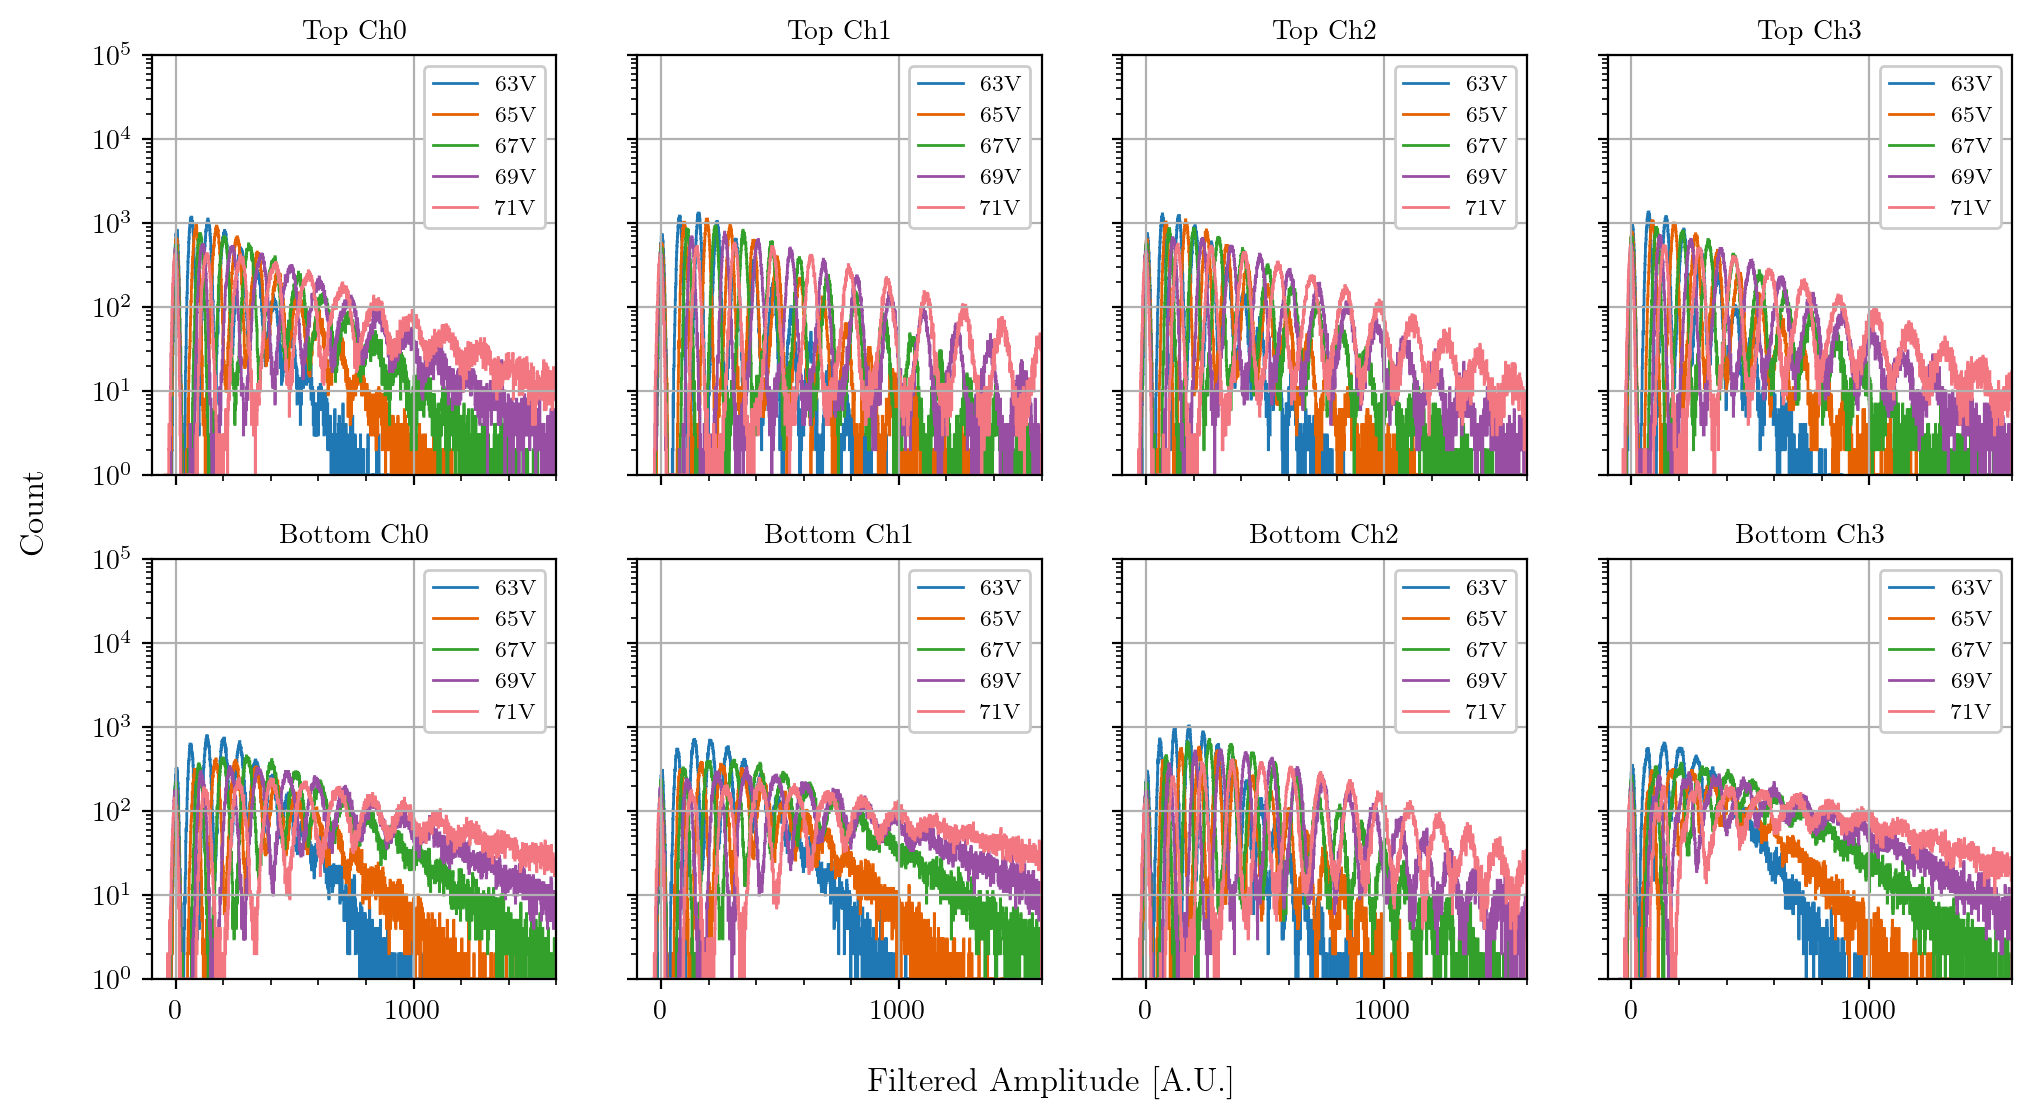

In [14]:
# Make plots for all datasets
# Finger plots
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            axs[i, j].stairs(calibration.amp_hist[pos][ch][volt]['hist'],
                             calibration.amp_hist[pos][ch][volt]['bins'],
                             label=f'{volt}V', color=f'C{k}')
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_ylim(1, 1e5)
        axs[i, j].set_xlim(calibration.amp_hist[pos][ch][volt]['bins'][0],
                           calibration.amp_hist[pos][ch][volt]['bins'][-1])
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel('Filtered Amplitude [A.U.]', y=0.01)
fig.supylabel('Count', x=0.07)

In [15]:
calibration.crosstalk_analysis()

top ch0 63V P_dict = 0.1226 +/- 0.0019
top ch0 65V P_dict = 0.1709 +/- 0.0064
top ch0 67V P_dict = 0.2230 +/- 0.0038
top ch0 69V P_dict = 0.2782 +/- 0.0048
top ch0 71V P_dict = 0.3388 +/- 0.0056
top ch1 63V P_dict = 0.1192 +/- 0.0073
top ch1 65V P_dict = 0.1789 +/- 0.0052
top ch1 67V P_dict = 0.2253 +/- 0.0051
top ch1 69V P_dict = 0.2811 +/- 0.0072
top ch1 71V P_dict = 0.3488 +/- 0.0066
top ch2 63V P_dict = 0.1158 +/- 0.0059
top ch2 65V P_dict = 0.1691 +/- 0.0063
top ch2 67V P_dict = 0.2201 +/- 0.0053
top ch2 69V P_dict = 0.2721 +/- 0.0057
top ch2 71V P_dict = 0.3330 +/- 0.0050
top ch3 63V P_dict = 0.1164 +/- 0.0074
top ch3 65V P_dict = 0.1728 +/- 0.0036
top ch3 67V P_dict = 0.2220 +/- 0.0039
top ch3 69V P_dict = 0.2711 +/- 0.0082
top ch3 71V P_dict = 0.3334 +/- 0.0083
bottom ch0 63V P_dict = 0.1489 +/- 0.0076
bottom ch0 65V P_dict = 0.1976 +/- 0.0079
bottom ch0 67V P_dict = 0.2443 +/- 0.0083
bottom ch0 69V P_dict = 0.2934 +/- 0.0050
bottom ch0 71V P_dict = 0.3458 +/- 0.0093
bottom ch1

Text(0.07, 0.5, 'Probability $P_k$')

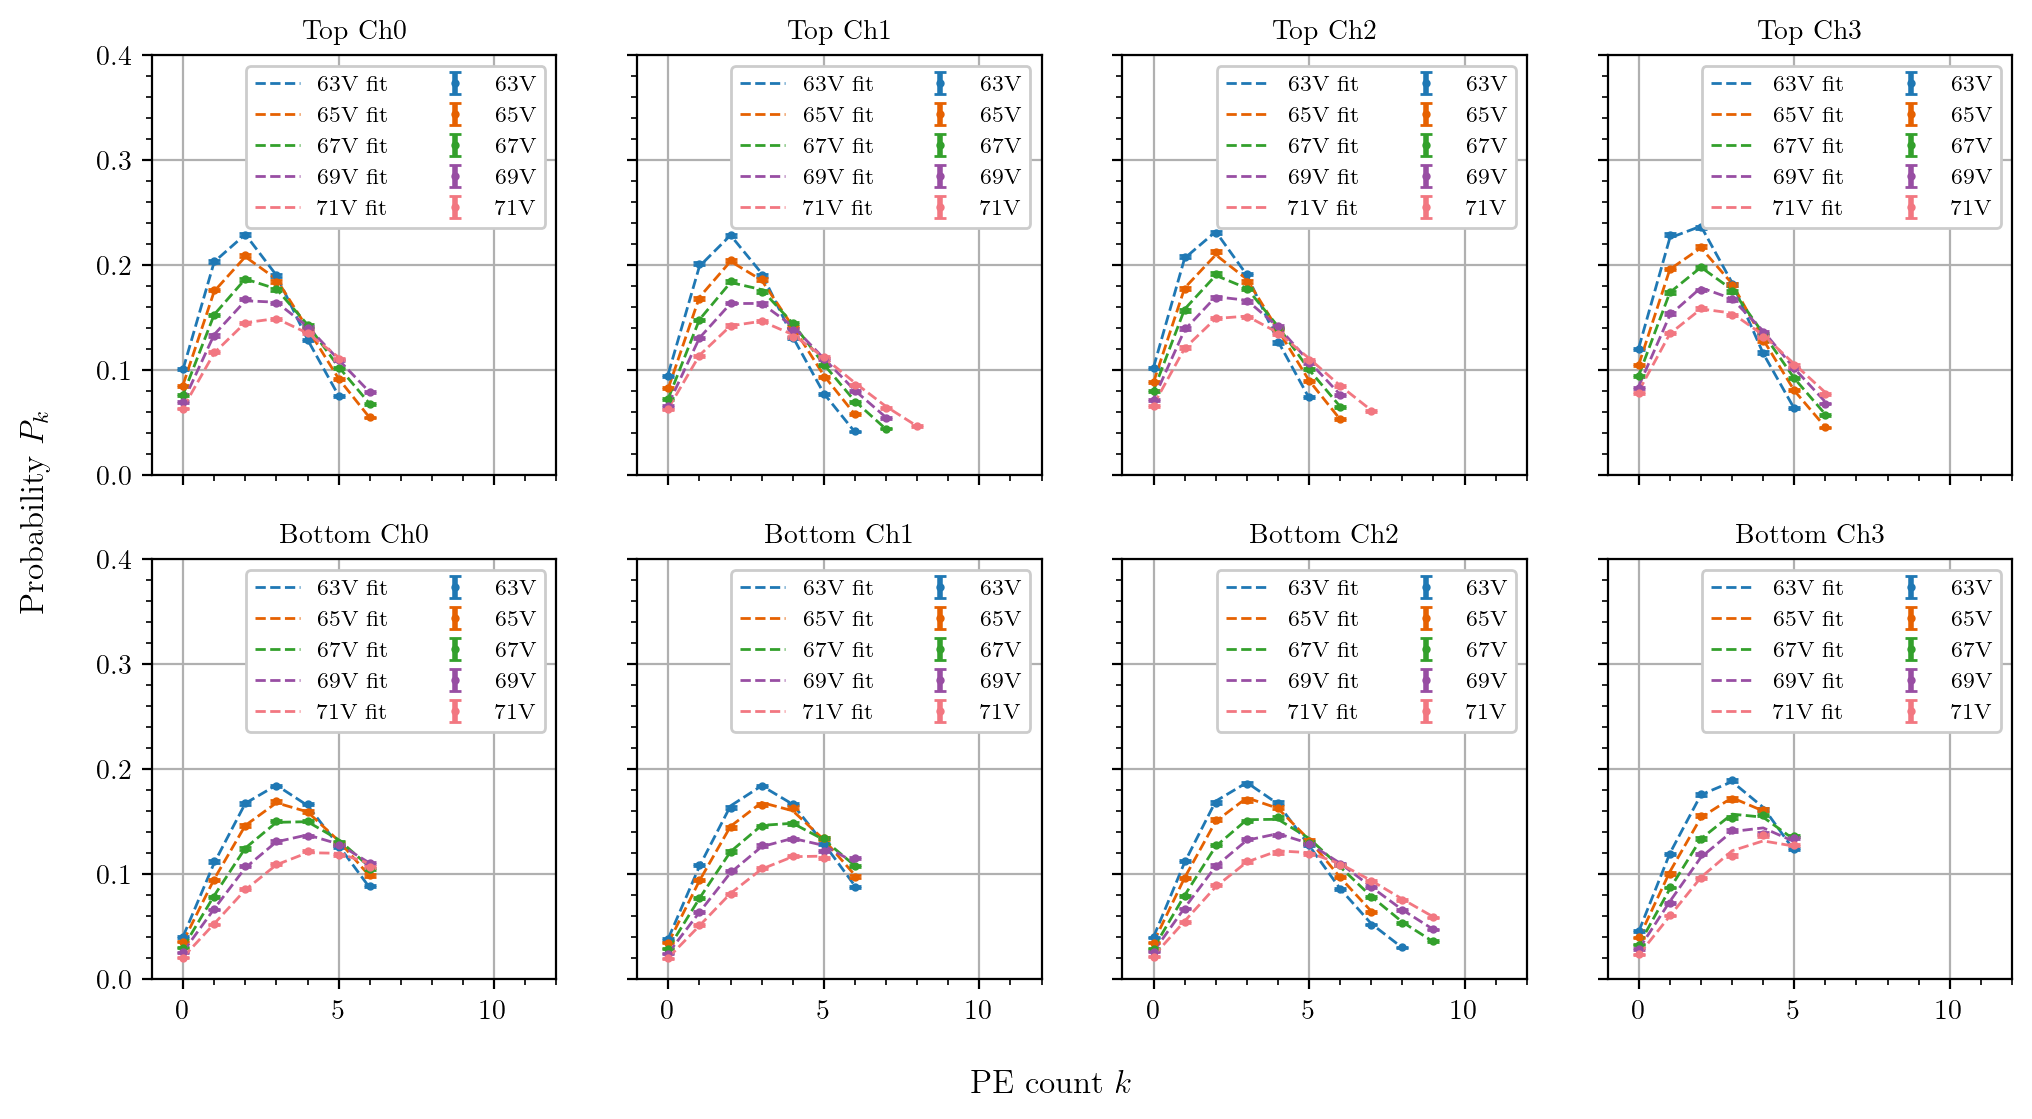

In [16]:
# Make plots for all datasets
# DiCT fits
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            axs[i, j].errorbar(calibration.crosstalk[pos][ch][volt]['x'],
                               calibration.crosstalk[pos][ch][volt]['y'],
                               yerr=calibration.crosstalk[pos][ch][volt]['yerr'],
                               fmt=f'C{k}o', markersize=2, label=f'{volt}V')
            axs[i, j].plot(calibration.crosstalk[pos][ch][volt]['x'],
                           func.compound_poisson(
                               calibration.crosstalk[pos][ch][volt]['x'], *calibration.crosstalk[pos][ch][volt]['par']),
                           f'C{k}--', label=f'{volt}V fit', linewidth=1)
        axs[i, j].legend(loc='upper right', ncol=2)
        axs[i, j].set_ylim(0, 0.4)
        axs[i, j].set_xlim(-1, 12)
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'PE count $k$', y=0.01)
fig.supylabel(r'Probability $P_k$', x=0.07)

Plots for bottom ch2 71V


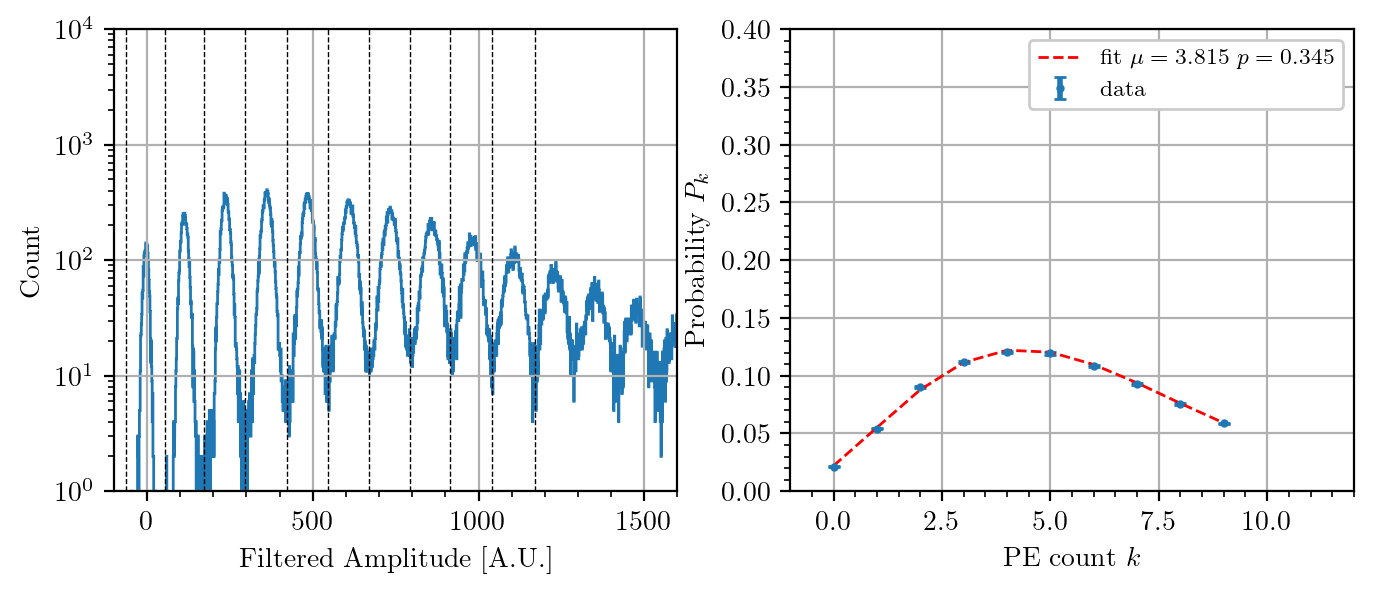

In [17]:
# Make plots for selected datasets
pos = 'bottom'
ch = 2
volt = 71
print(f'Plots for {pos} ch{ch} {volt}V')
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3)

# filtered amplitude histogram
axs[0].stairs(calibration.amp_hist[pos][ch][volt]['hist'],
              calibration.amp_hist[pos][ch][volt]['bins'])
for b in calibration.amp_hist[pos][ch][volt]['boundaries']:
    axs[0].plot([b, b], [1, 1e4], 'k--', linewidth=0.5)
axs[0].set_yscale('log')
axs[0].set_xlabel('Filtered Amplitude [A.U.]')
axs[0].set_ylabel('Count')
axs[0].set_xlim(calibration.amp_hist[pos][ch][volt]['bins'][0],
                calibration.amp_hist[pos][ch][volt]['bins'][-1])
axs[0].set_ylim(1, 1e4)
axs[0].minorticks_on()
axs[0].grid()

# Vinogradov fit
axs[1].errorbar(calibration.crosstalk[pos][ch][volt]['x'],
                calibration.crosstalk[pos][ch][volt]['y'],
                yerr=calibration.crosstalk[pos][ch][volt]['yerr'],
                fmt='o', markersize=2, label='data')
axs[1].plot(calibration.crosstalk[pos][ch][volt]['x'],
            func.compound_poisson(
                calibration.crosstalk[pos][ch][volt]['x'], *calibration.crosstalk[pos][ch][volt]['par']),
            'r--', label=r'fit $\mu={:.3f}$ $p={:.3f}$'.format(*calibration.crosstalk[pos][ch][volt]['par']), linewidth=1)
axs[1].set_xlabel(r'PE count $k$')
axs[1].set_ylabel(r'Probability $P_k$')
axs[1].set_ylim(0, 0.4)
axs[1].set_xlim(-1, 12)
axs[1].legend(loc='upper right')
axs[1].minorticks_on()
axs[1].grid()

# Integrated charge and afterpulsing analysis
The integral window is $5~\rm\mu s$ post-trigger and $0.5~\rm \mu s$ pre-trigger.
The integrals are grouped by the PE counts $k$ defined with the filtered amplitude (see previous cell).
The integral distribution has a Gaussian left tail but a heavier right tail due to afterpulses.
The part of the histograms near the peak is fitted by a Gaussian PDF to find the peak position, denoted by $I_{k,\rm peak}$.
$I_{k,\rm peak}$ is linear with $k$, and the slope $Q_{\rm peak}$ is the SPE gain of the SiPMs in arbitrary units.<br>

The average of the histogram, excluding overflowing bins (to reject scintillation events that have very high charge integrals), is denoted by $I_{k,\rm avg}$.
It is also linear with $k$, and the slope is denoted by $Q_{\rm avg}$.
The relative difference, $\frac{Q_{\rm avg}}{Q_{\rm peak}}-1$, is the average afterpulse charge per PE enhanced by DiCT.
Therefore, we define the afterpulse charge as $Q_{\rm AP}=(\frac{Q_{\rm avg}}{Q_{\rm peak}}-1)(1-p)$.<br>

The afterpulse *probability* is also estimated using the fraction of events under the Gaussian (i.e. the normalization of Gaussian function) out of total events.
This fraction is the probability that all $k$ cells have no afterpulse, denoted by $1-P_{\rm AP}(k)$. It should equal to $(1-P_{\rm AP})^k$, where $P_{\rm AP}$ is the afterpulse probability per PE.
$P_{\rm AP}$ extracted from the fits are consistent with $Q_{\rm AP}$, indicating that most afterpulses are a full PE.

The breakdown voltage is obtained by a linear fit to $Q_{\rm peak}$ as a function of bias $V$ using $Q_{\rm peak}=C(V-V_{\rm bd})$.
A comparison of breakdown voltage across channels is further down in the notebook.

In [18]:
calibration.charge_analysis()

Text(0.07, 0.5, 'Count')

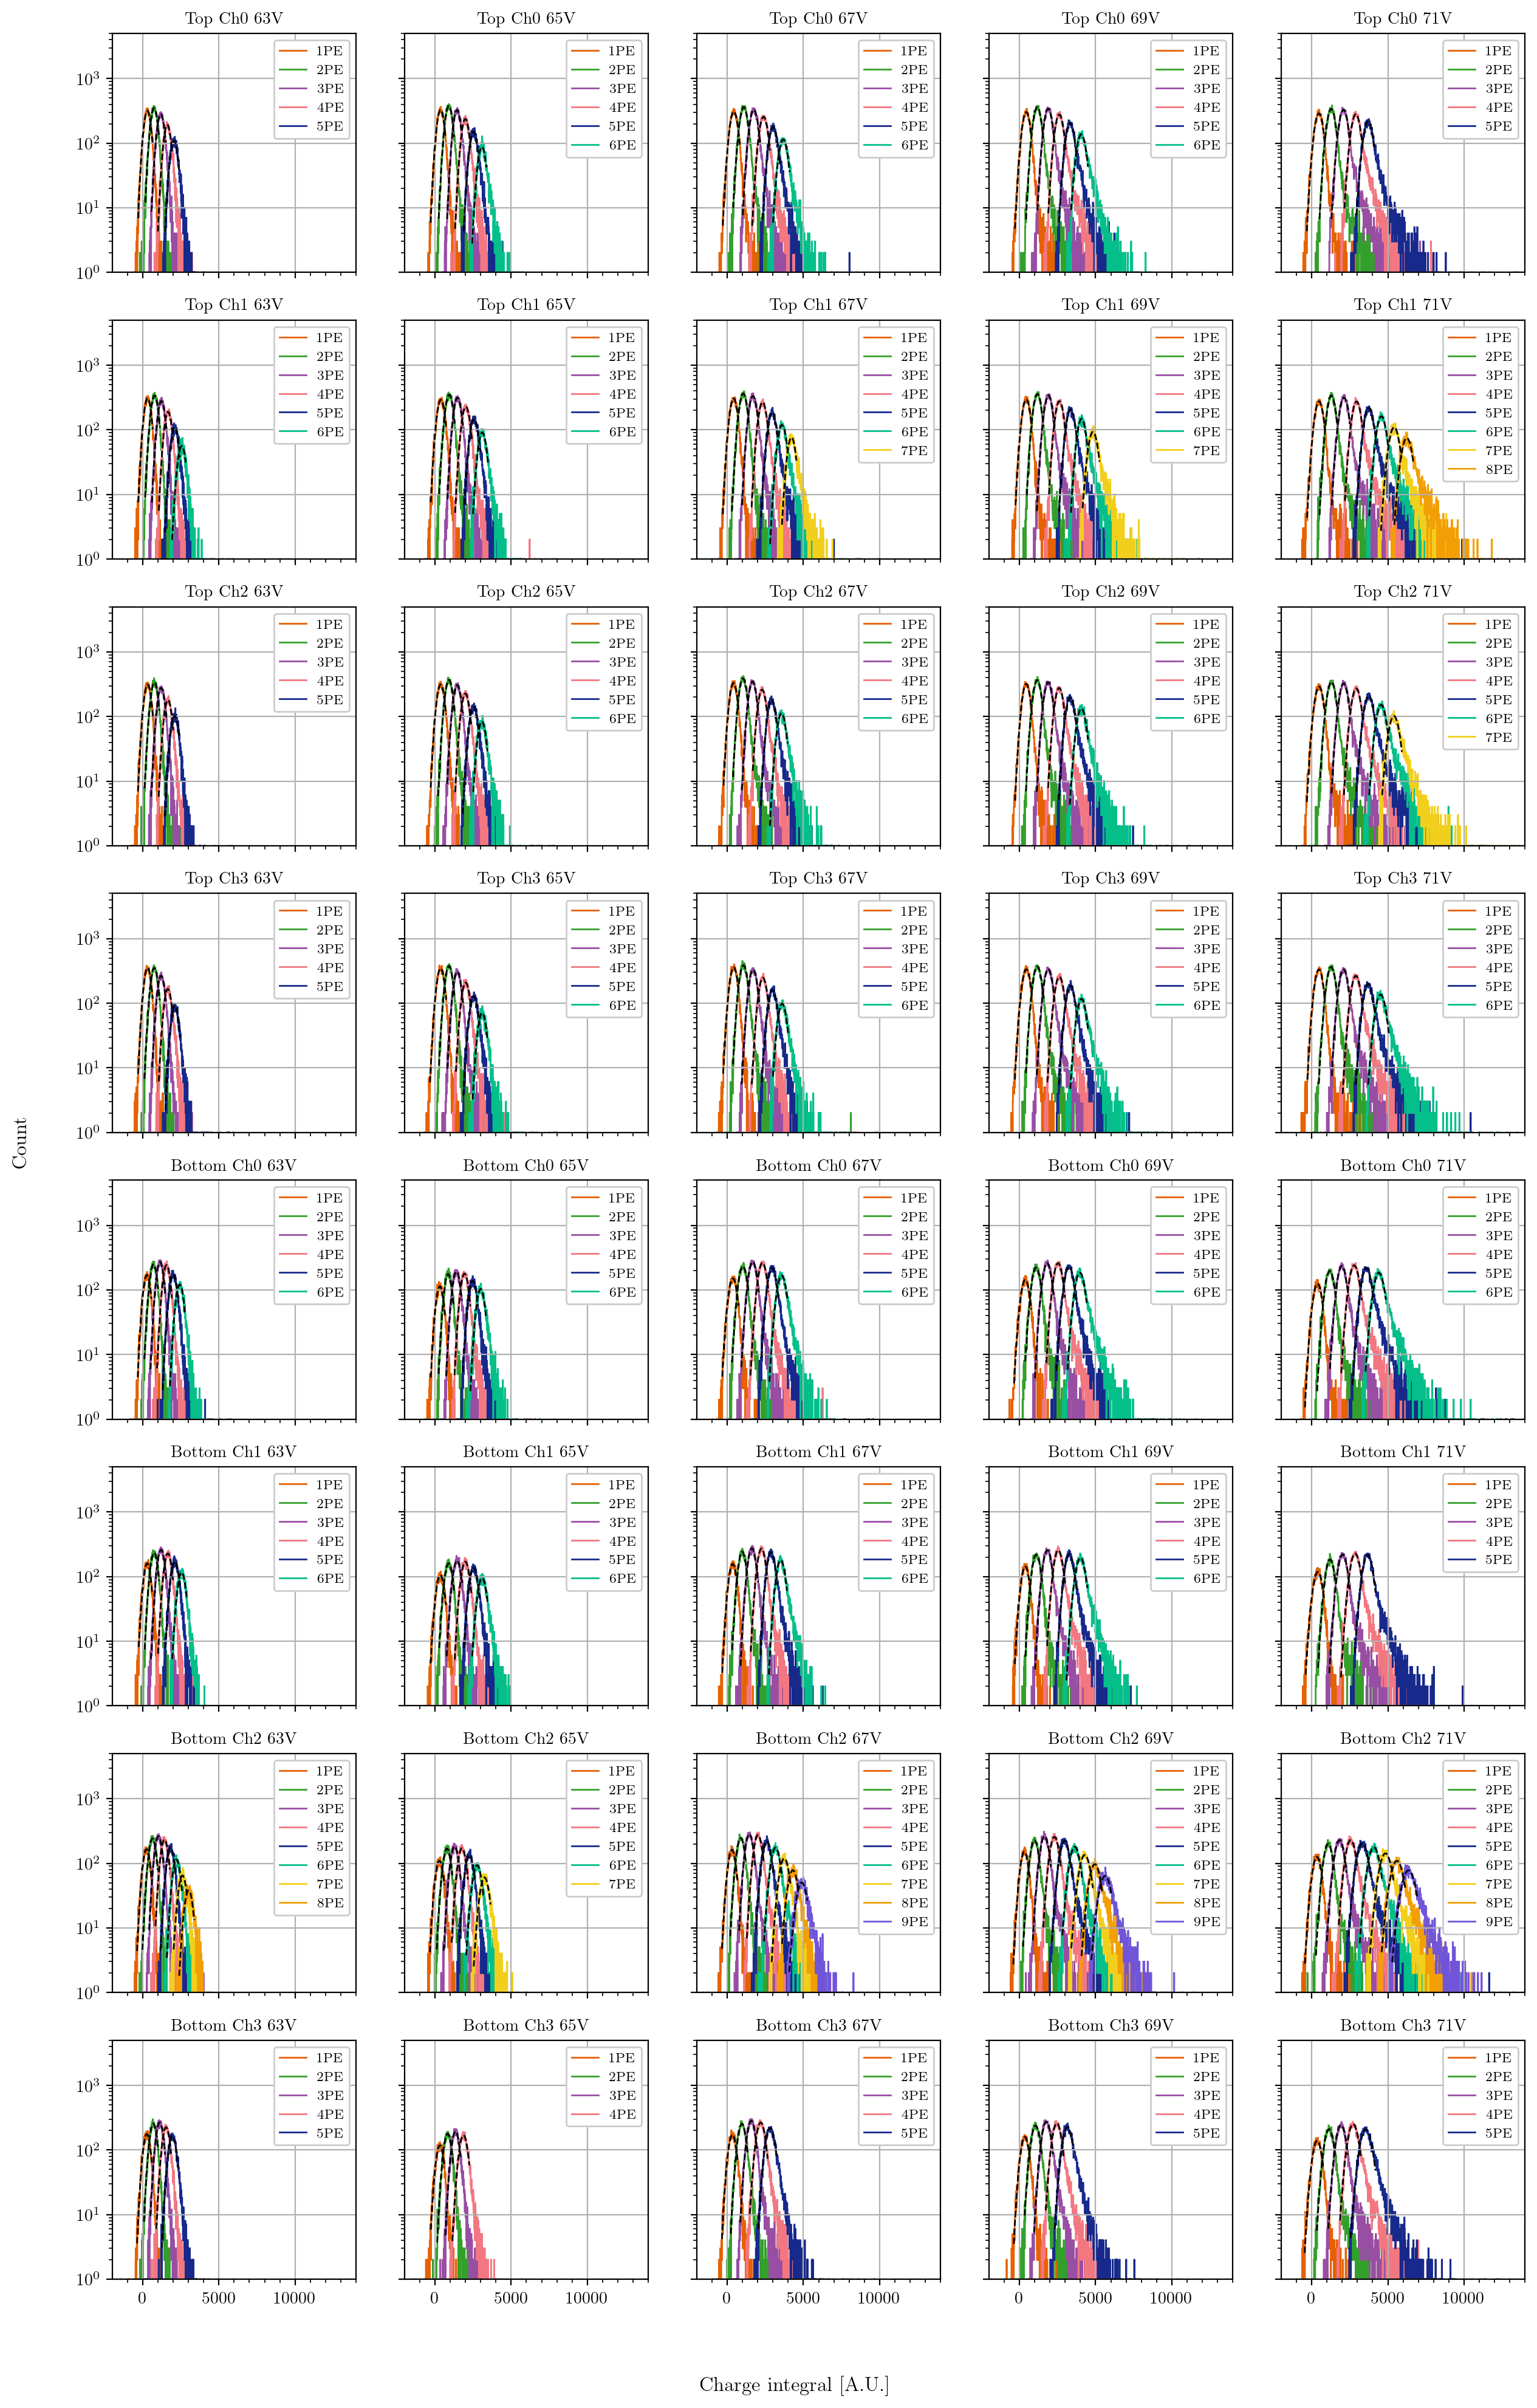

In [19]:
# Make plots for all datasets
# Charge histograms
fig, axs = plt.subplots(8, 5, sharex=True, sharey=True)
fig.set_size_inches(15, 24)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            for pe in calibration.charge_hist[pos][ch][volt].keys():
                axs[i*4+j, k].stairs(calibration.charge_hist[pos][ch][volt][pe]['hist'],
                                     calibration.charge_hist[pos][ch][volt][pe]['bins'], label=f'{pe}PE', color=f'C{pe}')
                fit_min = calibration.charge_fits[pos][ch][volt][pe]['min_bin']
                fit_max = calibration.charge_fits[pos][ch][volt][pe]['max_bin']
                axs[i*4+j, k].plot(calibration.charge_hist[pos][ch][volt][pe]['bins'][fit_min:fit_max], func.gauss_normalized(
                    calibration.charge_hist[pos][ch][volt][pe]['bins'][fit_min:fit_max], *calibration.charge_fits[pos][ch][volt][pe]['par']), f'k--', linewidth=1)
            axs[i*4+j, k].legend(loc='upper right')
            axs[i*4+j, k].set_ylim(1, 5e3)
            xmin = calibration.charge_hist[pos][ch][volt][list(
                calibration.charge_hist[pos][ch][volt].keys())[-1]]['bins'][0]
            xmax = calibration.charge_hist[pos][ch][volt][list(
                calibration.charge_hist[pos][ch][volt].keys())[-1]]['bins'][-1]
            axs[i*4+j, k].set_xlim(xmin, xmax)
            axs[i*4+j, k].set_yscale('log')
            axs[i*4+j, k].minorticks_on()
            axs[i*4+j, k].grid()
            axs[i*4+j,
                k].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch} {volt}V')
fig.supxlabel(r'Charge integral [A.U.]', y=0.07)
fig.supylabel(r'Count', x=0.07)

In [20]:
calibration.gain_analysis()

Text(0.07, 0.5, 'Charge integral $I_k$ [A.U.]')

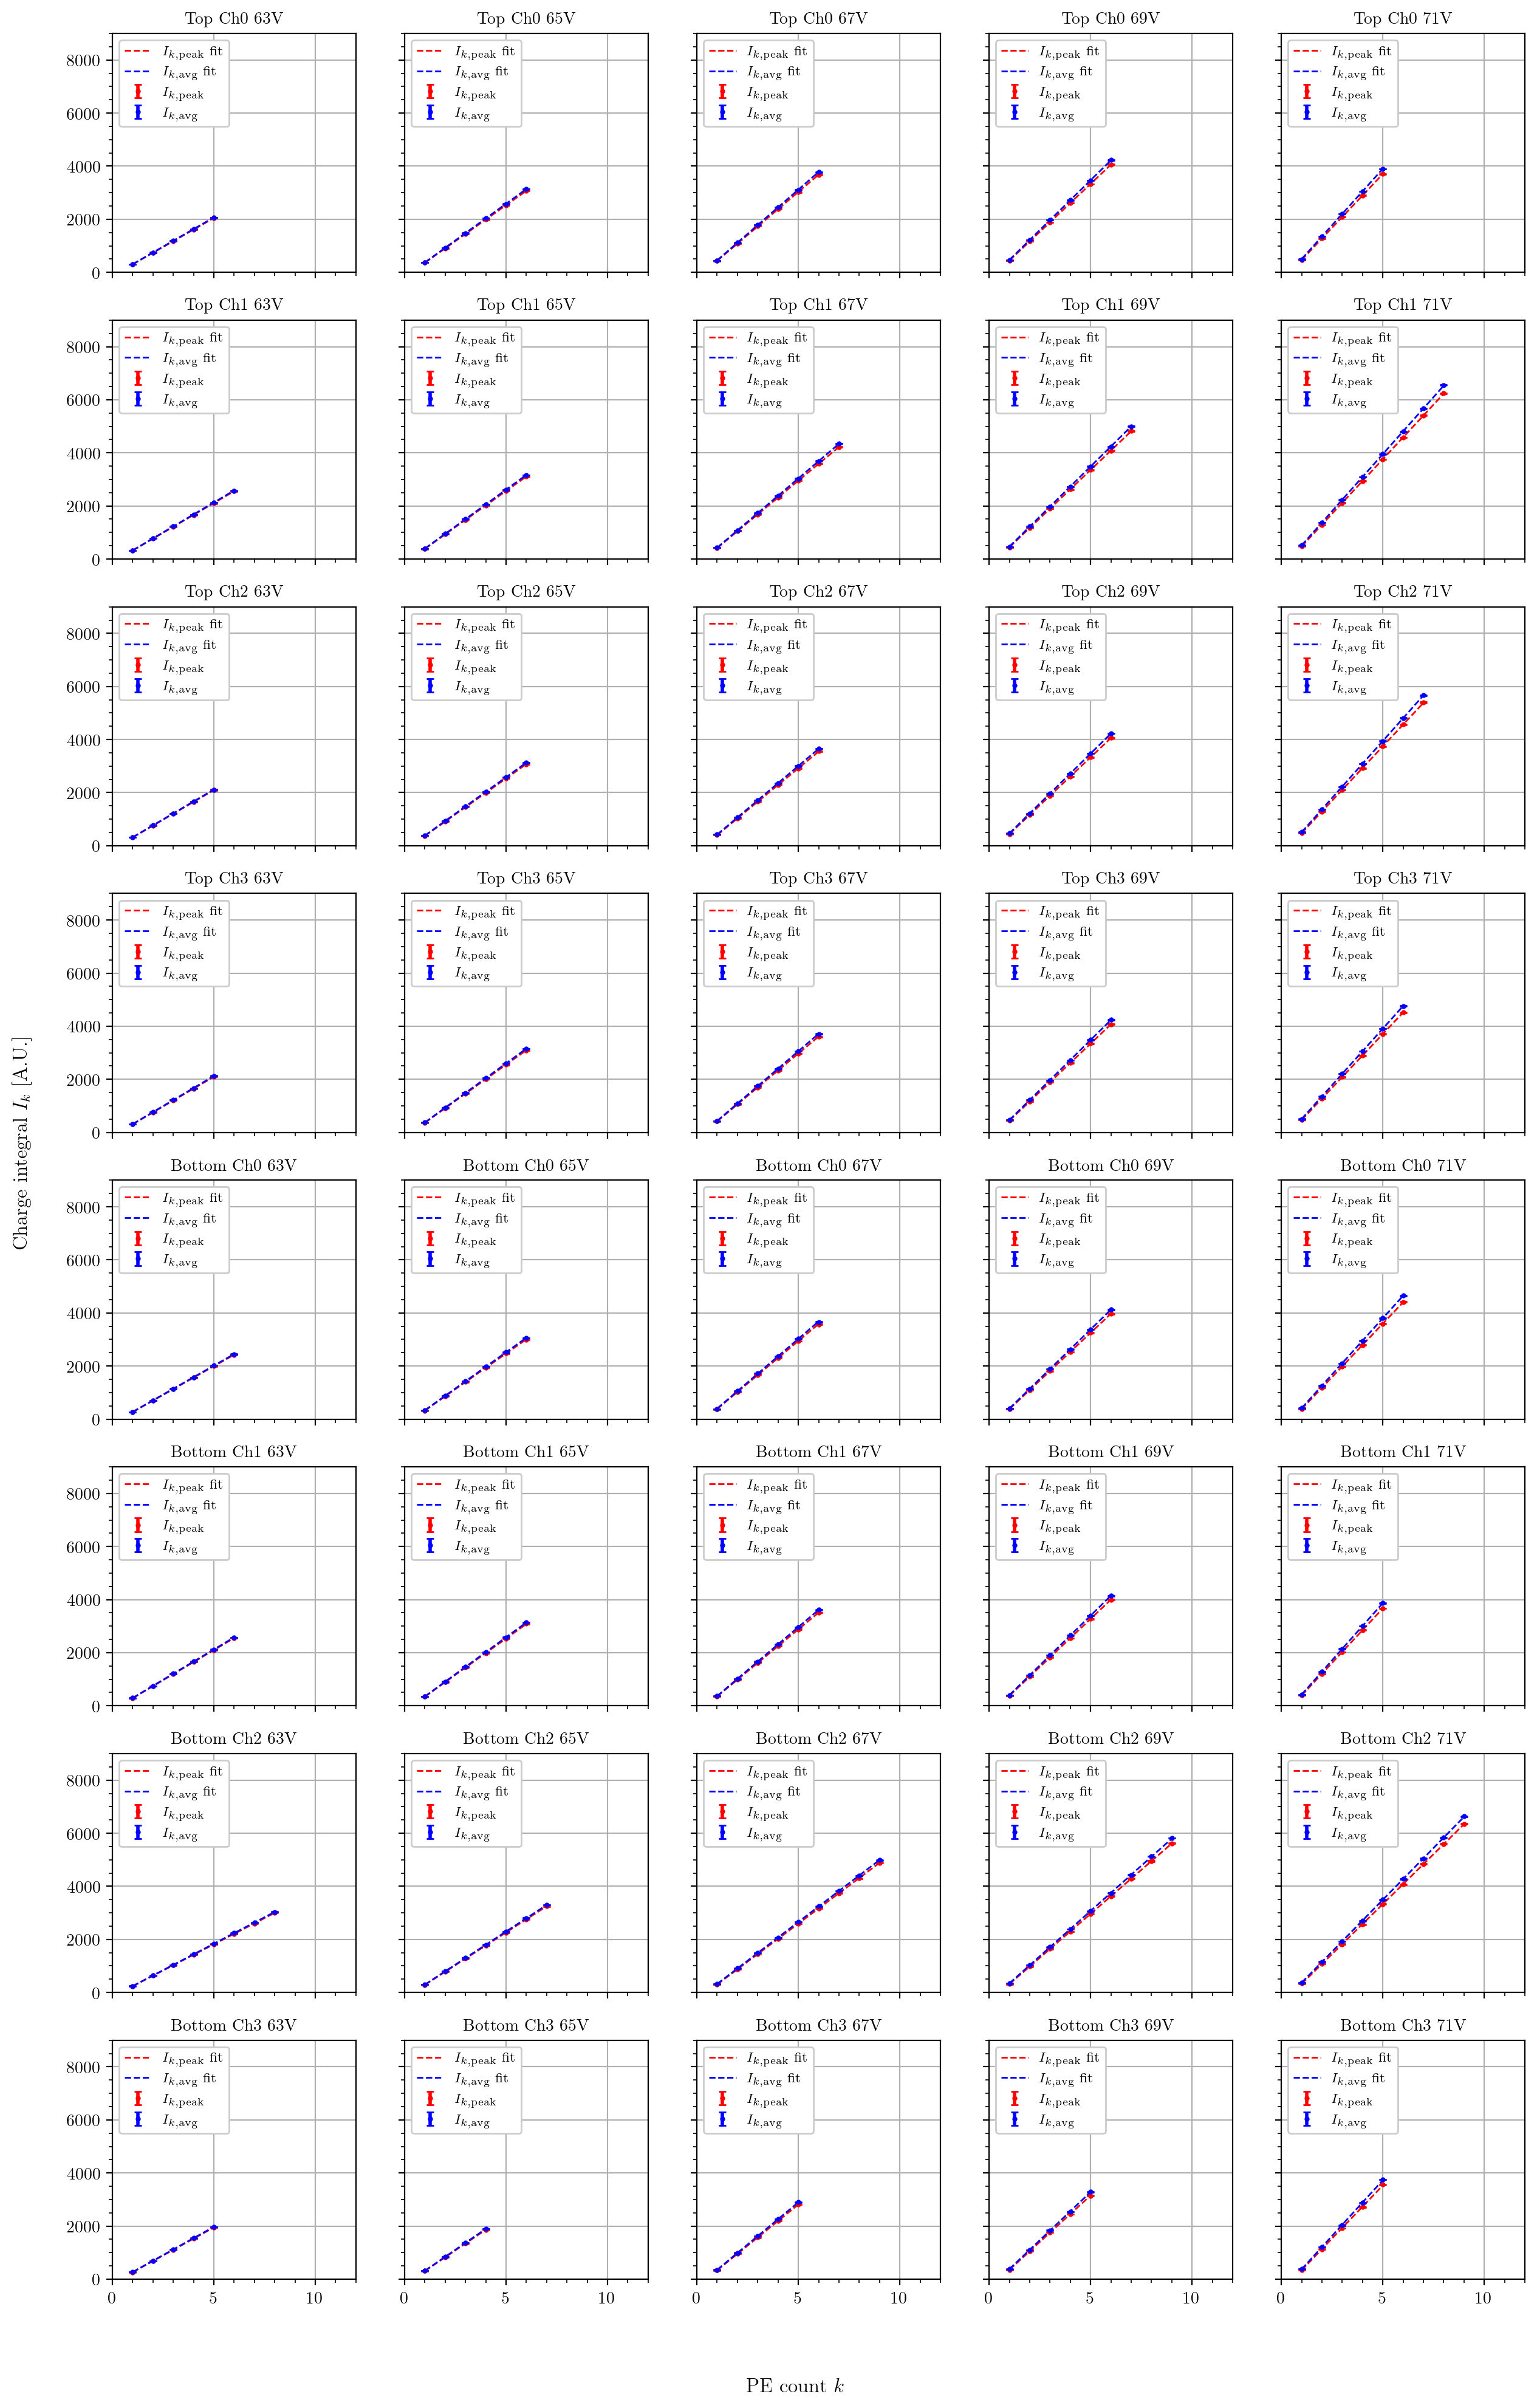

In [21]:
# Make plots for all datasets
# Charge-PE fits
fig, axs = plt.subplots(8, 5, sharex=True, sharey=True)
fig.set_size_inches(15, 24)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            axs[i*4+j, k].errorbar(calibration.gain_peak_fits[pos][ch][volt]['x'], calibration.gain_peak_fits[pos][ch][volt]['y'],
                                   yerr=calibration.gain_peak_fits[pos][ch][volt]['yerr'], fmt='ro', markersize=2, label=r'$I_{k,\rm peak}$')
            axs[i*4+j, k].plot(calibration.gain_peak_fits[pos][ch][volt]['x'], func.line_simple(calibration.gain_peak_fits[pos][ch][volt]
                               ['x'], *calibration.gain_peak_fits[pos][ch][volt]['par']), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
            axs[i*4+j, k].errorbar(calibration.gain_avg_fits[pos][ch][volt]['x'], calibration.gain_avg_fits[pos][ch][volt]['y'],
                                   yerr=calibration.gain_avg_fits[pos][ch][volt]['yerr'], fmt='bo', markersize=2, label=r'$I_{k,\rm avg}$')
            axs[i*4+j, k].plot(calibration.gain_avg_fits[pos][ch][volt]['x'], func.line_simple(calibration.gain_avg_fits[pos][ch][volt]
                               ['x'], *calibration.gain_avg_fits[pos][ch][volt]['par']), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
            axs[i*4+j, k].legend(loc='upper left')
            axs[i*4+j, k].set_ylim(0, 9e3)
            axs[i*4+j, k].set_xlim(0, 12)
            axs[i*4+j, k].minorticks_on()
            axs[i*4+j, k].grid()
            axs[i*4+j,
                k].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch} {volt}V')
fig.supxlabel(r'PE count $k$', y=0.07)
fig.supylabel(r'Charge integral $I_k$ [A.U.]', x=0.07)

In [22]:
calibration.afterpulse_analysis()

Text(0.03, 0.5, '$1-P_{\\rm AP}(k)$')

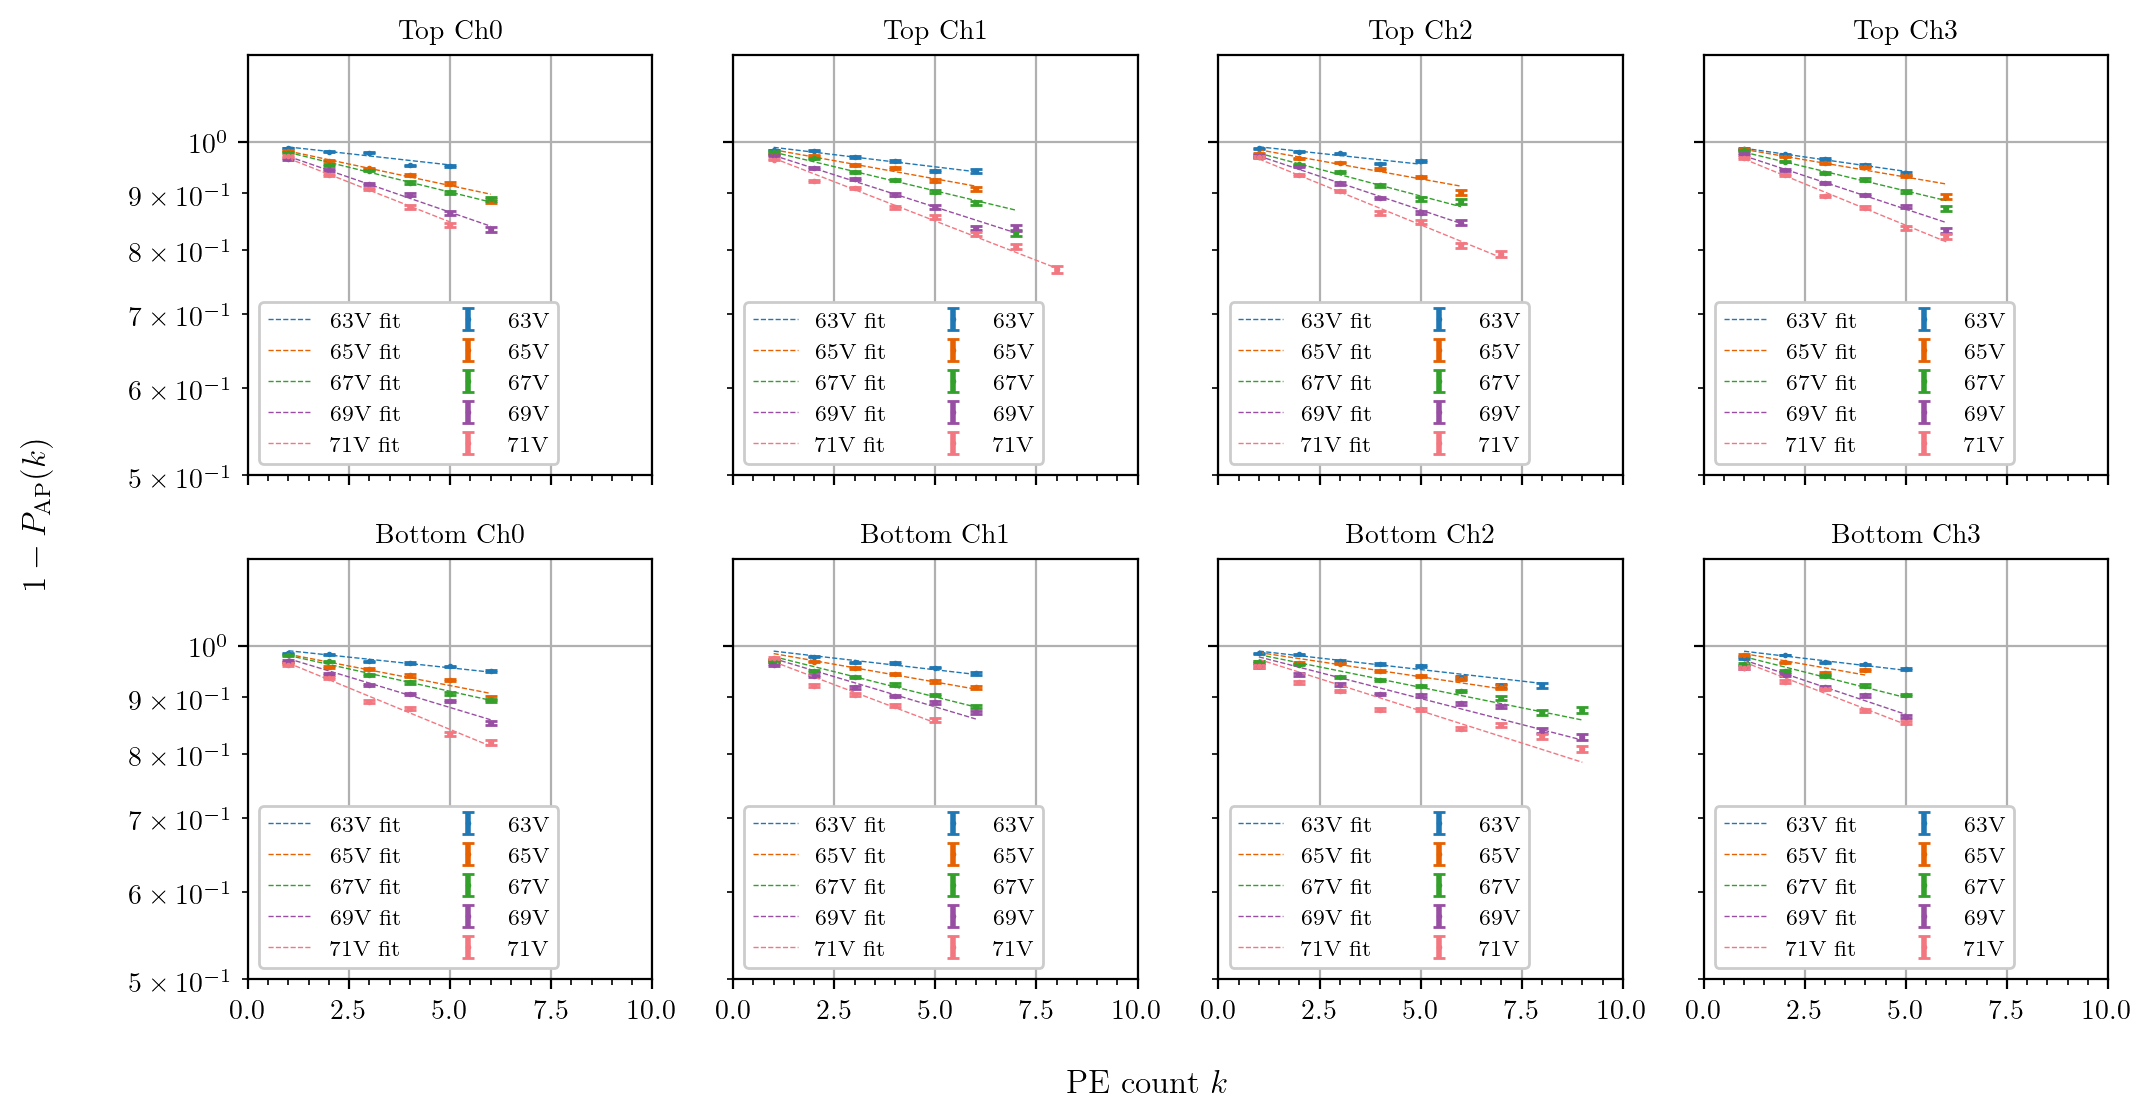

In [23]:
# Make plots for all datasets
# Afterpulse probability fits
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            axs[i, j].errorbar(calibration.ap_prob_fits[pos][ch][volt]['x'], calibration.ap_prob_fits[pos][ch][volt]['y'],
                               yerr=calibration.ap_prob_fits[pos][ch][volt]['yerr'], fmt=f'C{k}o', markersize=1, label=f'{volt}V')
            axs[i, j].plot(calibration.ap_prob_fits[pos][ch][volt]['x'], func.power(calibration.ap_prob_fits[pos][ch][volt]['x'],
                           *calibration.ap_prob_fits[pos][ch][volt]['par']), f'C{k}--', linewidth=0.5, label=f'{volt}V fit')
        axs[i, j].legend(loc='lower left', ncol=2)
        axs[i, j].set_ylim(0.5, 1.2)
        axs[i, j].set_xlim(0, 10)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'PE count $k$', y=0.01)
fig.supylabel(r'$1-P_{\rm AP}(k)$', x=0.03)

Plots for top ch3 71V


(0.0, 1.0, 0.0, 1.0)

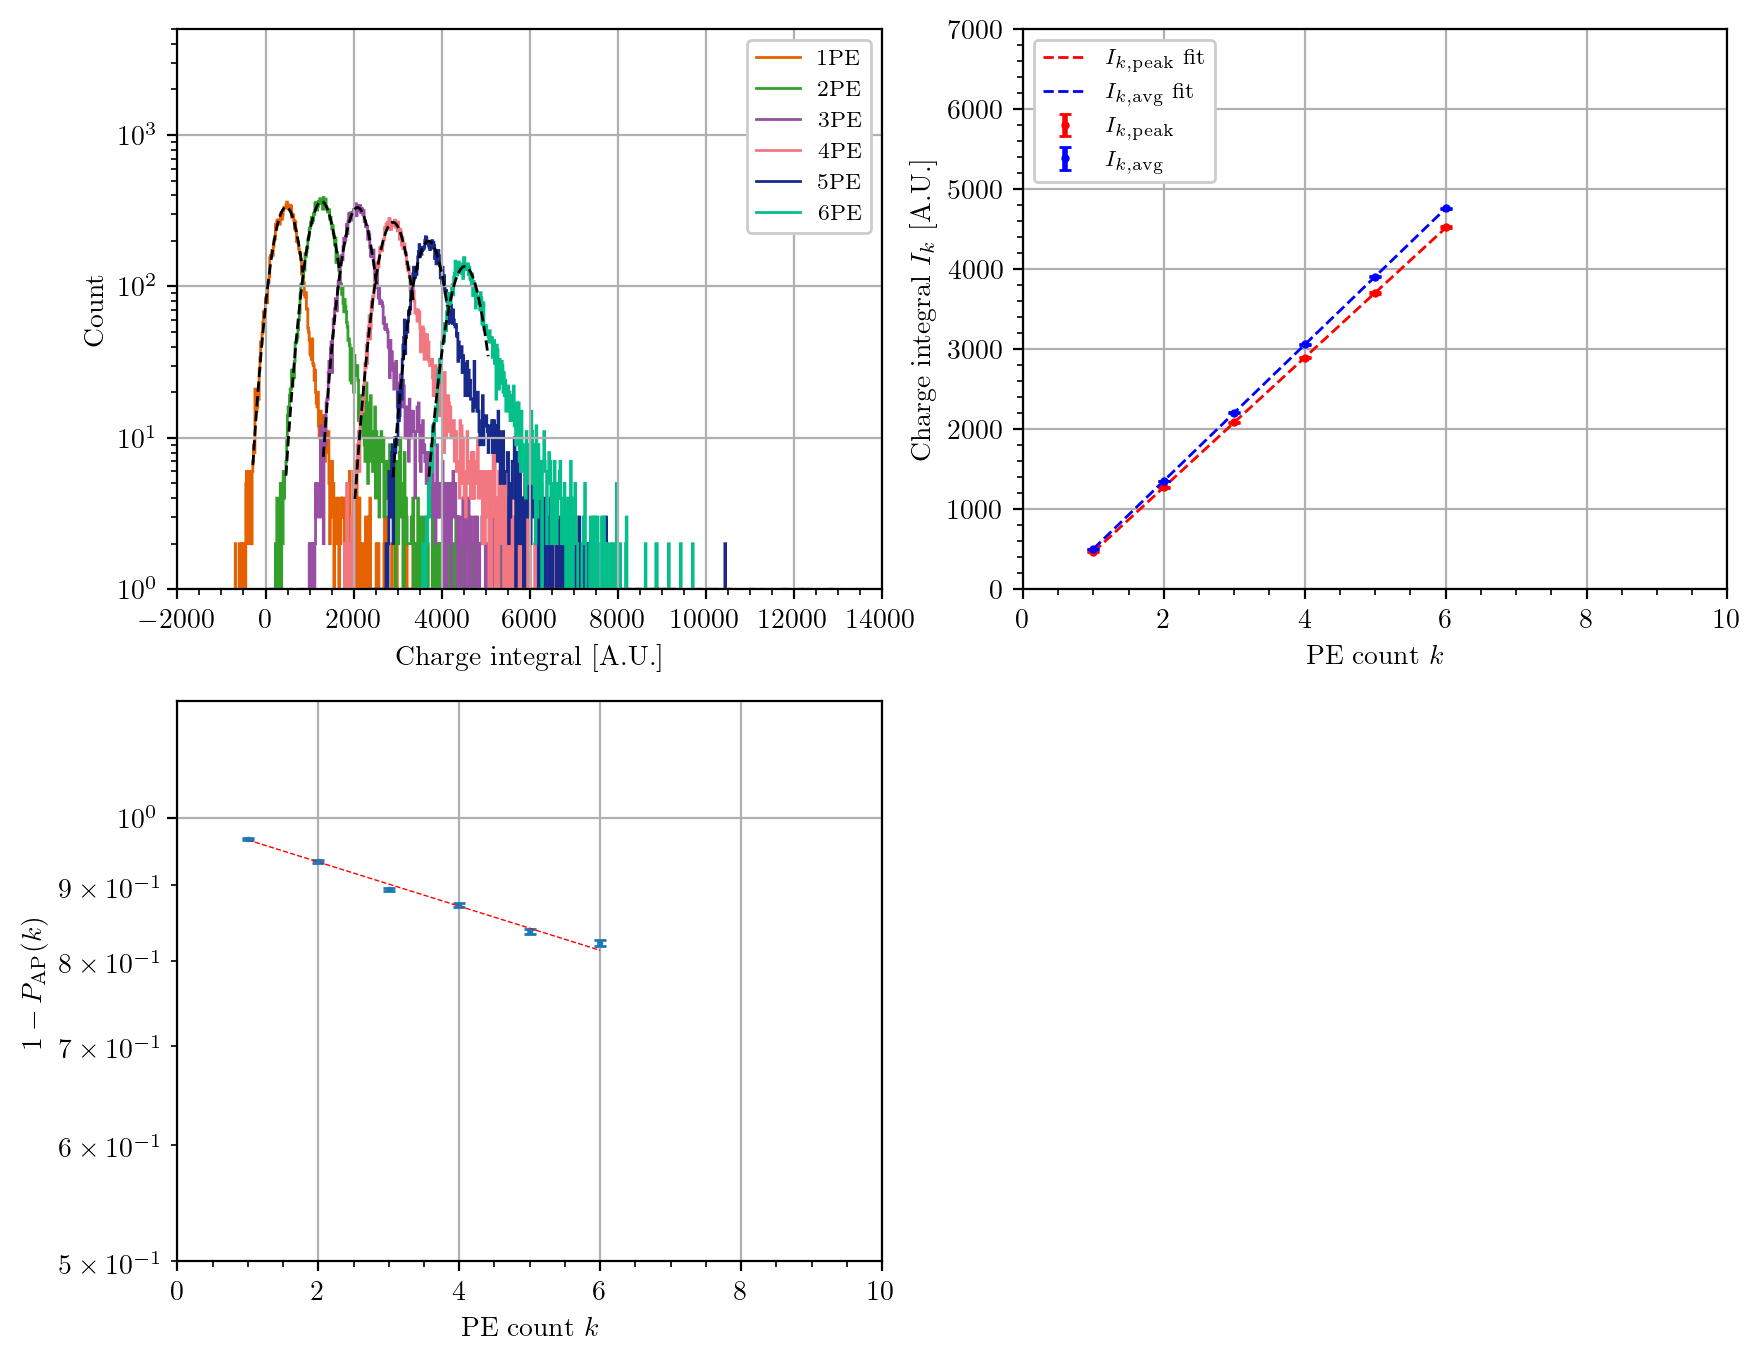

In [24]:
# Make plots for selected datasets
pos = 'top'
ch = 3
volt = 71
print(f'Plots for {pos} ch{ch} {volt}V')
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10, 8)

# charge histograms
for pe in calibration.charge_hist[pos][ch][volt].keys():
    axs[0, 0].stairs(calibration.charge_hist[pos][ch][volt][pe]['hist'],
                     calibration.charge_hist[pos][ch][volt][pe]['bins'], label=f'{pe}PE', color=f'C{pe}')
    fit_min = calibration.charge_fits[pos][ch][volt][pe]['min_bin']
    fit_max = calibration.charge_fits[pos][ch][volt][pe]['max_bin']
    axs[0, 0].plot(calibration.charge_hist[pos][ch][volt][pe]['bins'][fit_min:fit_max], func.gauss_normalized(
        calibration.charge_hist[pos][ch][volt][pe]['bins'][fit_min:fit_max], *calibration.charge_fits[pos][ch][volt][pe]['par']), f'k--', linewidth=1)
axs[0, 0].legend(loc='upper right')
axs[0, 0].set_ylim(1, 5e3)
xmin = calibration.charge_hist[pos][ch][volt][list(
    calibration.charge_hist[pos][ch][volt].keys())[-1]]['bins'][0]
xmax = calibration.charge_hist[pos][ch][volt][list(
    calibration.charge_hist[pos][ch][volt].keys())[-1]]['bins'][-1]
axs[0, 0].set_xlim(xmin, xmax)
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlabel(r'Charge integral [A.U.]')
axs[0, 0].set_ylabel(r'Count')
axs[0, 0].minorticks_on()
axs[0, 0].grid()

# charge-pe linear fits
axs[0, 1].errorbar(calibration.gain_peak_fits[pos][ch][volt]['x'], calibration.gain_peak_fits[pos][ch][volt]['y'],
                   yerr=calibration.gain_peak_fits[pos][ch][volt]['yerr'], fmt='ro', markersize=2, label=r'$I_{k,\rm peak}$')
axs[0, 1].plot(calibration.gain_peak_fits[pos][ch][volt]['x'], func.line_simple(calibration.gain_peak_fits[pos][ch][volt]
               ['x'], *calibration.gain_peak_fits[pos][ch][volt]['par']), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
axs[0, 1].errorbar(calibration.gain_avg_fits[pos][ch][volt]['x'], calibration.gain_avg_fits[pos][ch][volt]['y'],
                   yerr=calibration.gain_avg_fits[pos][ch][volt]['yerr'], fmt='bo', markersize=2, label=r'$I_{k,\rm avg}$')
axs[0, 1].plot(calibration.gain_avg_fits[pos][ch][volt]['x'], func.line_simple(calibration.gain_avg_fits[pos][ch][volt]
               ['x'], *calibration.gain_avg_fits[pos][ch][volt]['par']), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
axs[0, 1].legend()
axs[0, 1].set_xlabel(r'PE count $k$')
axs[0, 1].set_ylabel(r'Charge integral $I_k$ [A.U.]')
axs[0, 1].set_xlim(0, 10)
axs[0, 1].set_ylim(0, 7e3)
axs[0, 1].legend()
axs[0, 1].grid()
axs[0, 1].minorticks_on()

# afterpulse probability
axs[1, 0].errorbar(calibration.ap_prob_fits[pos][ch][volt]['x'],
                   calibration.ap_prob_fits[pos][ch][volt]['y'],
                   yerr=calibration.ap_prob_fits[pos][ch][volt]['yerr'],
                   fmt='o',
                   markersize=1)
axs[1, 0].plot(calibration.ap_prob_fits[pos][ch][volt]['x'],
               func.power(calibration.ap_prob_fits[pos][ch][volt]['x'],
                          *calibration.ap_prob_fits[pos][ch][volt]['par']),
               'r--',
               linewidth=0.5)
axs[1, 0].set_xlim(0, 10)
axs[1, 0].set_ylim(0.5, 1.2)
axs[1, 0].set_yscale('log')
axs[1, 0].minorticks_on()
axs[1, 0].grid()
axs[1, 0].set_xlabel(r'PE count $k$')
axs[1, 0].set_ylabel(r'$1-P_{\rm AP}(k)$')

# empty figure
axs[1, 1].axis('off')

In [25]:
calibration.breakdown_analysis(nsipms=2)

top ch0 Vbd = 53.35 +/- 0.55 V
top ch1 Vbd = 53.35 +/- 0.15 V
top ch2 Vbd = 53.40 +/- 0.09 V
top ch3 Vbd = 52.87 +/- 0.44 V
bottom ch0 Vbd = 53.87 +/- 0.33 V
bottom ch1 Vbd = 52.93 +/- 0.29 V
bottom ch2 Vbd = 54.08 +/- 0.29 V
bottom ch3 Vbd = 54.19 +/- 0.39 V


(0.0, 1000.0)

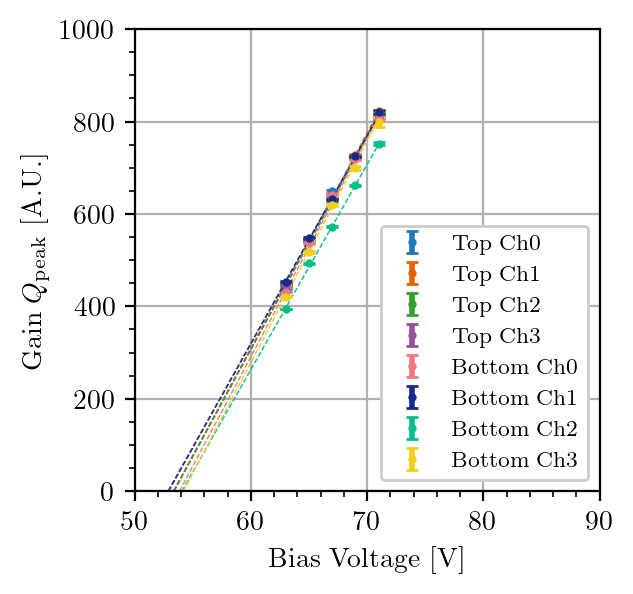

In [26]:
# Make plots for all datasets
# Gain-Vbias linear fits
fig, ax = plt.subplots(1)
fig.set_size_inches(3, 3)
for pos in positions:
    for ch in channels:
        ax.errorbar(calibration.vbd_fits[pos][ch]['x'],
                    calibration.vbd_fits[pos][ch]['y'],
                    yerr=calibration.vbd_fits[pos][ch]['yerr'],
                    label=f'{pos[0].upper()}{pos[1:]} Ch{ch}', fmt='C{}o'.format(ch+4*int(pos != 'top')), markersize=2)
        ax.plot(sorted(voltages + [calibration.vbd_fits[pos][ch]['vbd']]),
                func.line(np.array(sorted(voltages + [calibration.vbd_fits[pos][ch]['vbd']])), *calibration.vbd_fits[pos][ch]['par']),
                'C{}--'.format(ch+4*int(pos != 'top')), linewidth=0.5)
ax.legend(loc='lower right')
ax.set_xlabel('Bias Voltage [V]')
ax.set_ylabel(r'Gain $Q_{\rm peak}$ [A.U.]')
ax.grid()
ax.minorticks_on()
ax.set_xlim(50, 90)
ax.set_ylim(0, 1.0e3)


Plots for top ch3


(0.0, 1000.0)

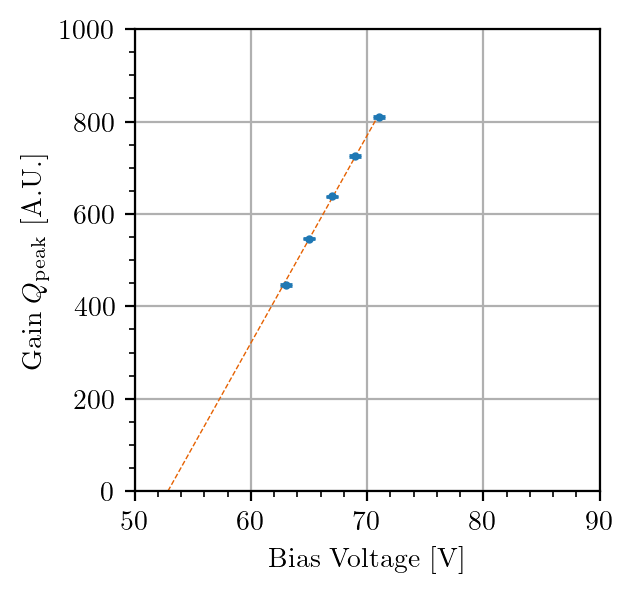

In [27]:
# Make plots for selected datasets
pos = 'top'
ch = 3
print(f'Plots for {pos} ch{ch}')
fig, ax = plt.subplots(1)
fig.set_size_inches(3, 3)
# Gain-Vbias linear fits
ax.errorbar(calibration.vbd_fits[pos][ch]['x'],
            calibration.vbd_fits[pos][ch]['y'],
            yerr=calibration.vbd_fits[pos][ch]['yerr'],
            label=f'{pos} ch{ch}', fmt='o', markersize=2)
ax.plot(sorted(voltages + [calibration.vbd_fits[pos][ch]['vbd']]),
        func.line(np.array(sorted(voltages + [calibration.vbd_fits[pos][ch]['vbd']])), *calibration.vbd_fits[pos][ch]['par']),
        '--', linewidth=0.5)
ax.set_xlabel('Bias Voltage [V]')
ax.set_ylabel(r'Gain $Q_{\rm peak}$ [A.U.]')
ax.grid()
ax.minorticks_on()
ax.set_xlim(50, 90)
ax.set_ylim(0, 1.0e3)


# Summary

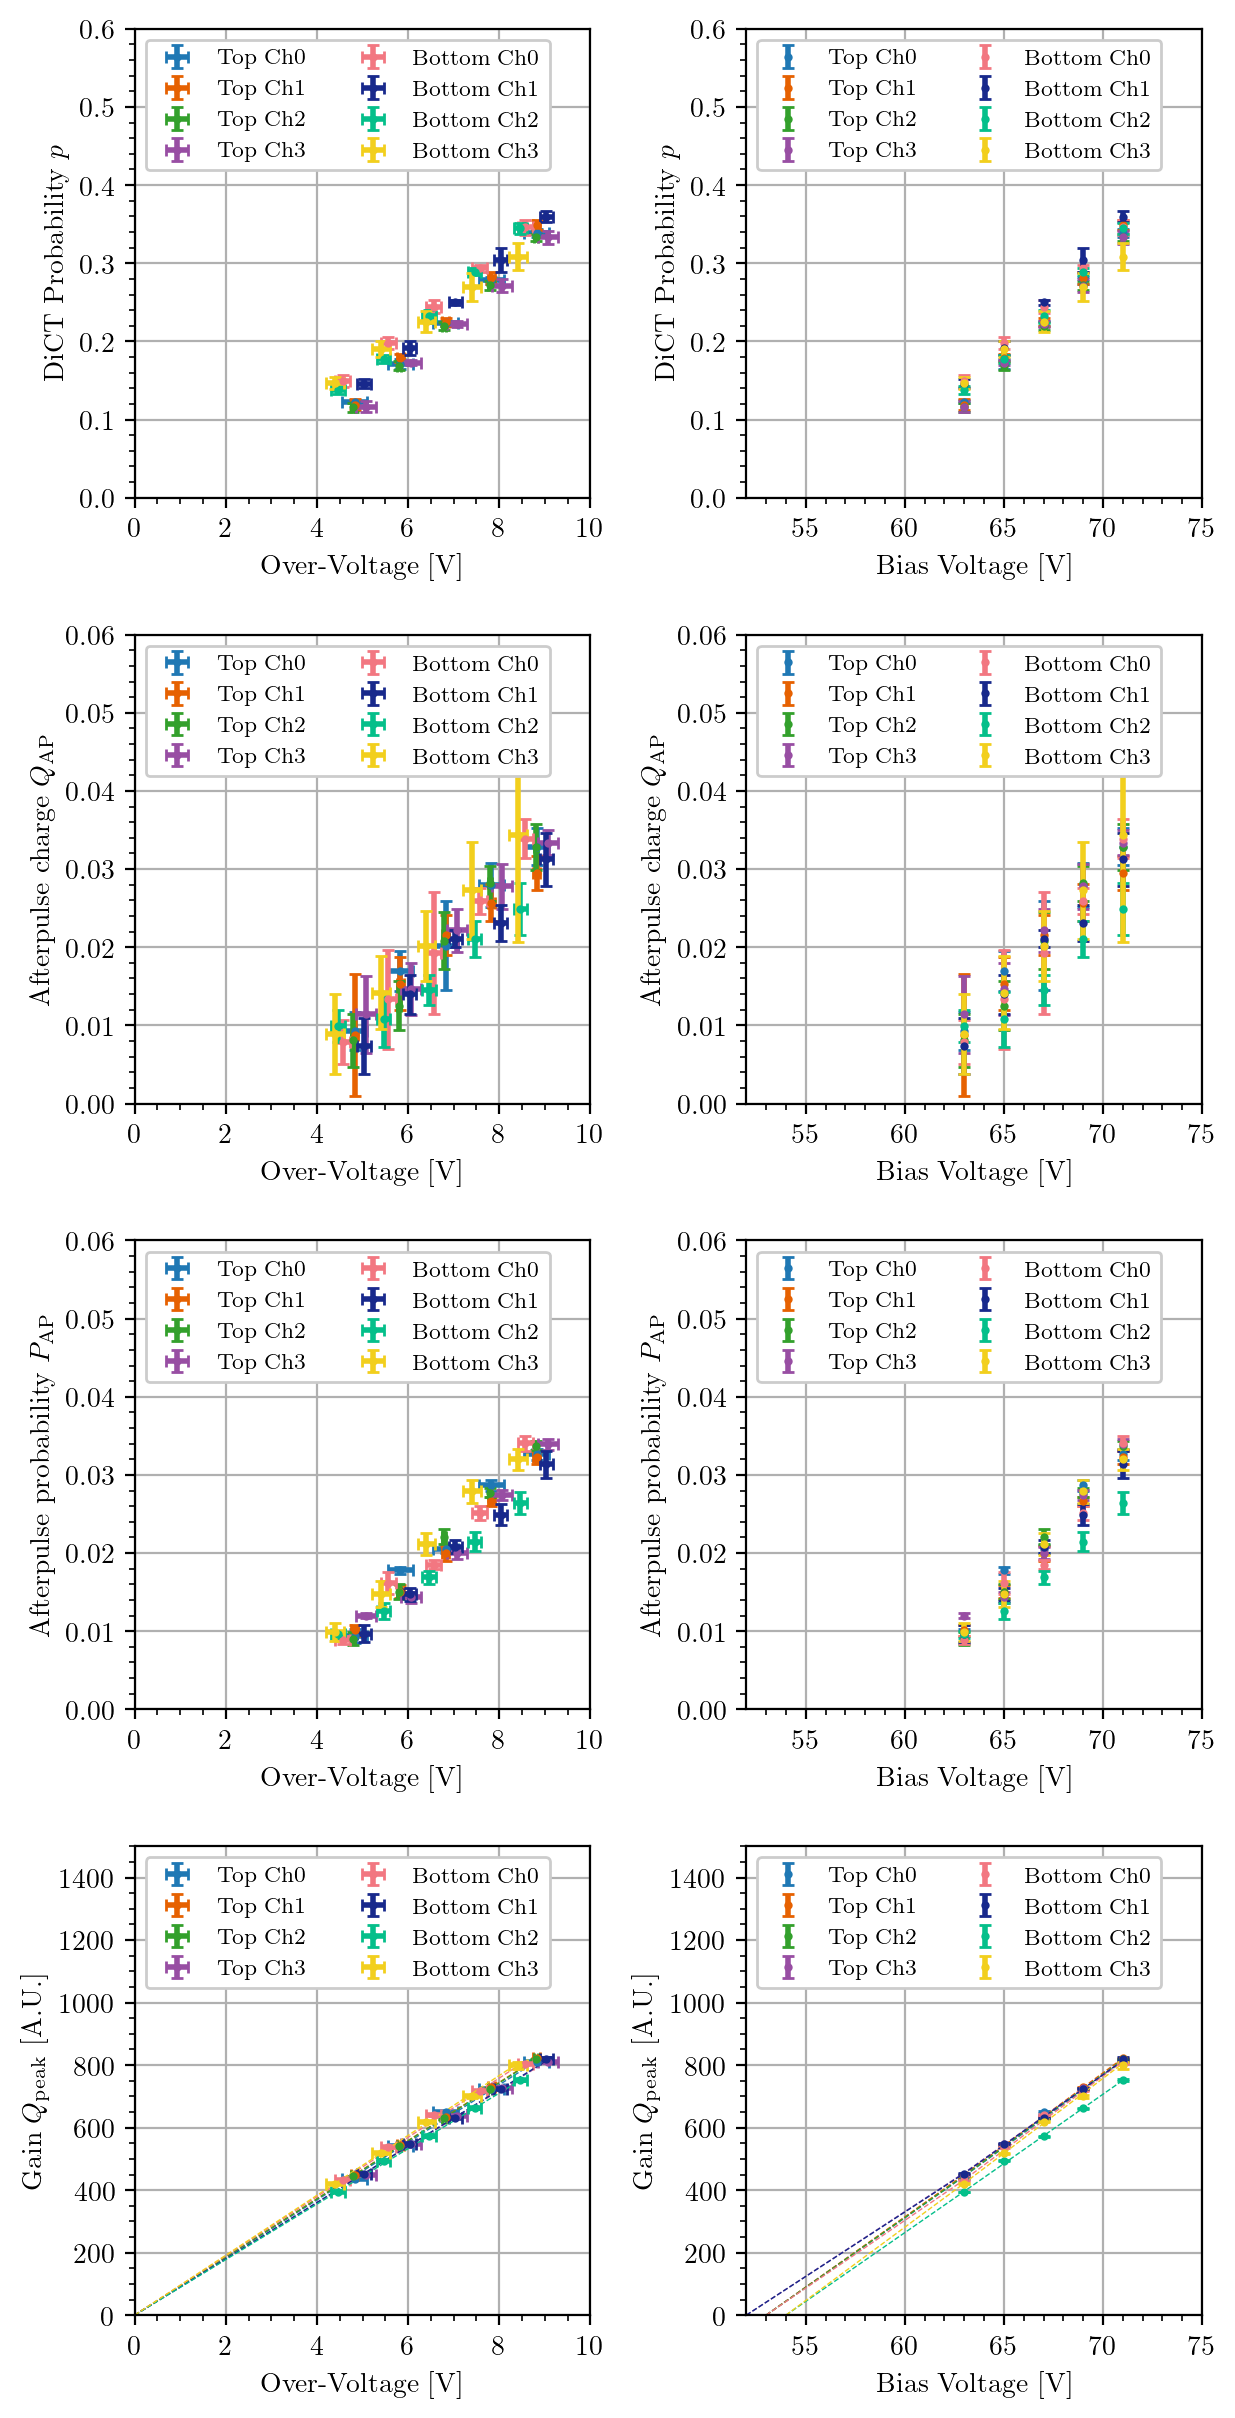

In [28]:
# Make summary plots
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

x_keys = ['ov','bias']
y_keys = ['dict','ap_charge', 'ap_prob', 'gain']
fig, axs = plt.subplots(len(y_keys),len(x_keys))
fig.set_size_inches(len(x_keys)*3, len(y_keys)*3)
fig.tight_layout(h_pad=3, w_pad=3)

for i,yk in enumerate(y_keys):
    for j,xk in enumerate(x_keys):
        for pos in positions:
            for ch in channels:
                if xk=='ov':
                    axs[i,j].errorbar(
                        calibration.results[yk][pos][ch][xk],
                        calibration.results[yk][pos][ch][yk],
                        xerr=calibration.results[yk][pos][ch][f'{xk}_err'],
                        yerr=calibration.results[yk][pos][ch][f'{yk}_err'],
                        label=f'{pos[0].upper()}{pos[1:]} Ch{ch}',
                        fmt='C{}o'.format(ch+4*int(pos != 'top')),
                        markersize=2)
                elif xk=='bias':
                    axs[i,j].errorbar(
                        calibration.results[yk][pos][ch][xk],
                        calibration.results[yk][pos][ch][yk],
                        yerr=calibration.results[yk][pos][ch][f'{yk}_err'],
                        label=f'{pos[0].upper()}{pos[1:]} Ch{ch}',
                        fmt='C{}o'.format(ch+4*int(pos != 'top')),
                        markersize=2)
                if yk=='gain':
                    if xk=='ov':
                        axs[i,j].plot(
                            np.insert(calibration.results['gain'][pos][ch]['ov'],0,0),
                            np.insert(calibration.results['gain'][pos][ch]['ov']*calibration.vbd_fits[pos][ch]['par'][0]*2,0,0),
                            'C{}--'.format(ch+4*int(pos != 'top')),
                            linewidth=0.5)
                    elif xk=='bias':
                        axs[i,j].plot(
                            np.insert(calibration.results['gain'][pos][ch]['bias'],0,calibration.vbd_fits[pos][ch]['vbd']),
                            np.insert((calibration.results['gain'][pos][ch]['bias']-calibration.vbd_fits[pos][ch]['vbd'])*calibration.vbd_fits[pos][ch]['par'][0],0,0),
                            'C{}--'.format(ch+4*int(pos != 'top')),
                            linewidth=0.5)
        axs[i,j].legend(ncol=2)
        if j==0:
            axs[i,j].set_xlabel(r'Over-Voltage [V]')
            axs[i,j].set_xlim(0, 10)
        else:
            axs[i,j].set_xlabel(r'Bias Voltage [V]')
            axs[i,j].set_xlim(52, 75)
        if i==0:
            axs[i,j].set_ylabel(r'DiCT Probability $p$')
            axs[i,j].set_ylim(0, 0.6)
        elif i==1:
            axs[i,j].set_ylabel(r'Afterpulse charge $Q_{\rm AP}$')
            axs[i,j].set_ylim(0, 0.06)
        elif i==2:
            axs[i,j].set_ylabel(r'Afterpulse probability $P_{\rm AP}$')
            axs[i,j].set_ylim(0, 0.06)
        elif i==3:
            axs[i,j].set_ylabel(r'Gain $Q_{\rm peak}$ [A.U.]')
            axs[i,j].set_ylim(0, 1.5e3)
        axs[i,j].grid()
        axs[i,j].minorticks_on()

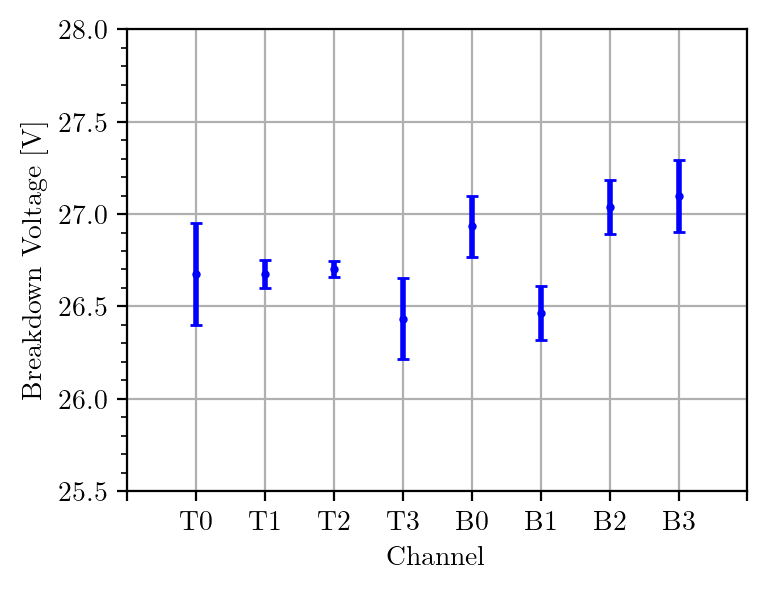

Breakdown voltage per SiPM = 26.72+/-0.03(stat) V
RMS variation = 0.25V


In [29]:
# Vbd-channel
fig, ax = plt.subplots()
channel_labels = []
for pos in positions:
    for ch in channels:
        plt.errorbar(
            [ch+4*int(pos != 'top')], 
            [calibration.results['vbd'][pos][ch]['vbd_sipm']],
            yerr=[calibration.results['vbd'][pos][ch]['vbd_sipm_err']],
            fmt='bo', markersize=2)
        channel_labels.append(f'{pos[0].upper()}{ch}')
plt.xlabel('Channel')
plt.ylabel('Breakdown Voltage [V]')
ax.xaxis.set(ticks=np.arange(len(positions)*len(channels)), ticklabels=channel_labels)
plt.xlim(-1, 8)
plt.ylim(25.5, 28)
plt.grid()
plt.minorticks_on()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_tick_params(which='minor', bottom=False)
plt.show()

# Analyze Vbd distribution
vbd_array = []
vbd_err_array = []
for pos in positions:
    for ch in channels:
        vbd_array.append(calibration.results['vbd'][pos][ch]['vbd_sipm'])
        vbd_err_array.append(calibration.results['vbd'][pos][ch]['vbd_sipm_err'])
vbd_array = np.array(vbd_array)
vbd_err_array = np.array(vbd_err_array)
vbd_avg = np.average(vbd_array, weights=1/vbd_err_array**2)
vbd_stat = np.sum(vbd_err_array**(-2))**(-0.5)
print('Breakdown voltage per SiPM = {:.2f}+/-{:.2f}(stat) V'.format(vbd_avg, vbd_stat))
vbd_rms = np.std(vbd_array, ddof=1)
print('RMS variation = {:.2f}V'.format(vbd_rms))

# Write to HDF5 file

In [30]:
calibration.write_to_h5(name='calibration_liq3')

In [31]:
for pos in positions:
    for volt in voltages:
        summary = pd.read_hdf('data/calibration_liq3.h5', key=f'/{pos}/{volt}V')
        print(f'{pos} {volt}V')
        print(summary)

top 63V
   channel      A1min       A1max      DiCT  DiCT_err        Qavg  Qavg_err  \
0        0  33.733333   99.466667  0.122649  0.001874  440.856112  0.238906   
1        1  39.400000  118.733333  0.119178  0.007337  451.530049  2.773216   
2        2  34.866667  101.733333  0.115780  0.005883  449.775799  1.687186   
3        3  37.133333  108.533333  0.116436  0.007393  453.008343  1.387682   

        Qpeak  Qpeak_err       Qap   Qap_err  bsl_rms  
0  436.229792   1.165511  0.009305  0.002417      2.5  
1  447.083314   2.784078  0.008761  0.007781      3.0  
2  445.699922   0.374844  0.008086  0.003430      2.5  
3  447.228963   2.064531  0.011418  0.004958      2.5  
top 65V
   channel      A1min       A1max      DiCT  DiCT_err        Qavg  Qavg_err  \
0        0  42.800000  127.800000  0.170872  0.006403  553.052849  1.418334   
1        1  49.600000  145.933333  0.178938  0.005203  554.854336  1.428778   
2        2  42.800000  123.266667  0.169103  0.006332  549.772840  1.30

## Calculate rENF versus bias/over-voltage

Following https://ieeexplore.ieee.org/document/5402300 closely, the reduced excess noise factor (rENF) here is defined as
$$\mathrm{rENF}(V_{\rm bias})=\frac{1+p_{\rm DiCT}(V_{\rm bias})}{\mu(V_{\rm bias})/\mu(63V)},$$
where $p_{\rm DiCT}$ is the DiCT probability, and $\mu$ is the parameter obtained from the Vinogradov fits.
Since the laser intensity did not change when taking data at different voltages, $\mu$ is the relative PDE. We choose $V_{\rm bias}=63V$ as the reference point.


In [32]:
calibration.calculate_renf()

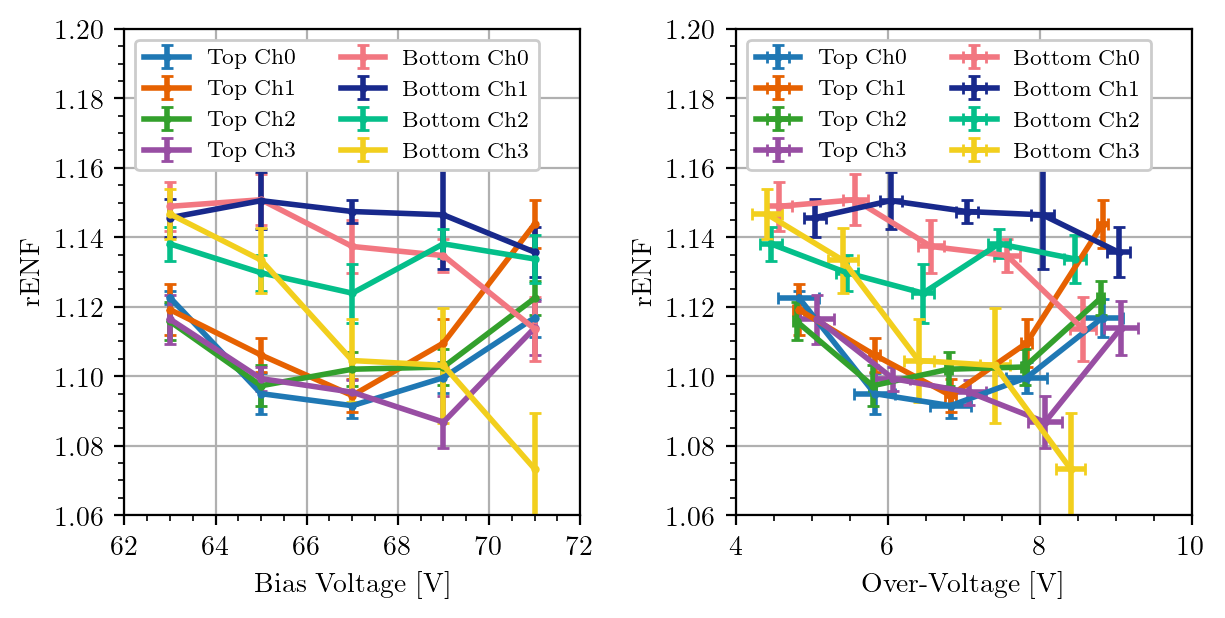

In [33]:
# Relative PDE: the mu parameter from the DiCT fits
fig, axs = plt.subplots(1,2)
fig.set_size_inches(6, 3)
fig.tight_layout(h_pad=3, w_pad=3)

for pos in positions:
    for ch in channels:
        axs[0].errorbar(
            calibration.results['renf'][pos][ch]['bias'],
            calibration.results['renf'][pos][ch]['renf'],
            yerr=calibration.results['renf'][pos][ch]['renf_err'],
            label=f'{pos[0].upper()}{pos[1:]} Ch{ch}',
            fmt='C{}o-'.format(ch+4*int(pos != 'top')),
            markersize=2)
        axs[1].errorbar(
            calibration.results['renf'][pos][ch]['ov'],
            calibration.results['renf'][pos][ch]['renf'],
            xerr=calibration.results['renf'][pos][ch]['ov_err'],
            yerr=calibration.results['renf'][pos][ch]['renf_err'],
            label=f'{pos[0].upper()}{pos[1:]} Ch{ch}',
            fmt='C{}o-'.format(ch+4*int(pos != 'top')),
            markersize=2)
for i in [0,1]:
    if i==0:
        axs[i].set_xlabel('Bias Voltage [V]')
    else:
        axs[i].set_xlabel('Over-Voltage [V]')
    axs[i].set_ylabel('rENF')
    axs[i].legend(ncol=2)
    axs[i].grid()
    axs[i].minorticks_on()
    axs[i].set_ylim(1.06,1.20)
    